# BTS Airline On Time Performance Overview

This notebook analyzes 3 years of US airline on-time performance data (Dec 2015 -  Nov 2018) from the Bureau of Transportation Statistics. This analysis also examines the estimated cost of insuring flight disruptions (with an assumption of a $500 replacement ticket cost). Disruptions include cancellations and delays greater than 4 hours. 

Data exploration examines disruption rate and average estimated replacement costs basis on various factors, such as airline ('carrier'), origin and destination airports, month of flight, day of week, and hour of day. 

Tweedie and Negative Binomial models were used to estimate cost of insuring flights. I also use an average of feature means models. An ensemble of all three estimates was also created.

# Table of Contents

0. Resources on Predictive Modeling with GLMs
1. Upload Data
2. Standard Imports
3. Load, Shrink and Concat DFs
4. Data Dictionaries
5. Data Transformations
6. Data Exploration and Visualization
 * Disruptions
 * Summary Stats on Disruption & Costs
 * Airport Stats
 * Carrier Stats
 * Month Stats
 * Route Stats
 * State Stats
 * Time Block Stats
 * Distance Group Stats
 * Other Disruption Rate Visualizations
 * Other Disruption Cost Visualizations

7. Key Insights
8. Sample Data for Model
9. Tweedie Model
10. Negative Binomial Model
11. Average Cost of Feature Means Model
11. Model on Test Data (Negative Binomial)
12. Function for Prediction (Negative Binomial)









## Resources on Predictive Modelings Using GLMs

* Poisson deviance
* Video: [link](https://youtu.be/z1AlNGXGz9A?t=499) and [here](https://youtu.be/z1AlNGXGz9A?t=901)
* Overview of GLMs: [Casact](https://www.casact.org/education/annual/2013/handouts/Paper_2858_handout_1467_0.pdf)
* Normalized Gini coefficient: [link](https://www.kaggle.com/c/liberty-mutual-fire-peril/discussion/9880)
* H20: [link](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/tweedie_power.html)
* PyPi: [Tweedie](https://pypi.org/project/tweedie/)
* StatsModels: [Tweedie](https://www.statsmodels.org/dev/generated/statsmodels.genmod.families.family.Tweedie.html), [GLMs](https://www.statsmodels.org/dev/glm.html), 
* XGBoost: [Tweedie](https://xgboost.readthedocs.io/en/latest/parameter.html)
* Poisson and Tweedie Distributions:[ link](https://appliedmachinelearning.blog/2018/08/31/lets-talk-about-numeric-distributions-python/)
* Scoring for Tweedie: [link](http://www.actuarialoutpost.com/actuarial_discussion_forum/showthread.php?p=9260202)
* Lift curve: [link](https://www.quora.com/Whats-Lift-curve)
* Tweedie: [Casact](https://www.casact.org/education/annual/2009/handouts/c25-meyers.pdf), [Another](https://www.casact.org/library/astin/vol32no1/143.pdf)

## Bayesian

* [Estimating Probabilities](https://towardsdatascience.com/estimating-probabilities-with-bayesian-modeling-in-python-7144be007815)

* [Koehrsen on Bayesian Regression](https://towardsdatascience.com/bayesian-linear-regression-in-python-using-machine-learning-to-predict-student-grades-part-2-b72059a8ac7e)

* [https://docs.pymc.io/Probability_Distributions.html](https://docs.pymc.io/Probability_Distributions.html)


# Upload Data

I took 3 years of data (Dec 2015 - Nov 2018) and condensed the file size in other notebooks. 

In [1]:
# upload zip
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving on_time_2016_2018.zip to on_time_2016_2018.zip
User uploaded file "on_time_2016_2018.zip" with length 283656812 bytes


In [2]:
!ls

on_time_2016_2018.zip  sample_data


In [3]:
# unzip data to directory "data"
!unzip on_time_2016_2018.zip -d data/

Archive:  on_time_2016_2018.zip
  inflating: data/on_time_2016_2018/on_time_2016.csv  
  inflating: data/on_time_2016_2018/on_time_2017.csv  
  inflating: data/on_time_2016_2018/on_time_2018.csv  


In [0]:
!ls

data  on_time_2016_2018.zip  sample_data


In [0]:
# remove zip file
!rm on_time_2016_2018.zip

In [5]:
# change directory to data directory
%cd data/on_time_2016_2018/

/content/data/on_time_2016_2018


In [6]:
!ls

on_time_2016.csv  on_time_2017.csv  on_time_2018.csv


# Imports

In [7]:
# standard libraries
import pandas as pd
import numpy as np
import os

# visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt

# classification models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# regression models
import statsmodels.api as sm
import xgboost as xgb

# suppress scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# ignore warnings
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn
warnings.filterwarnings("ignore", category=Warning)
print('Warnings will be ignored!')

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Warnings will be ignored!


# Load, Shrink, and Concat DFs

In [0]:
# function to analyze memory usage
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

In [0]:
# function to shrink dataframe size further
def shrink_df(filename):
    df = pd.read_csv(filename)
    print("Before: ", str(mem_usage(df)))
    df = df.rename(index=str, columns={"Reporting_Airline": "Carrier"})
    
    # create disruption feature from cancellations and delays
    df['Disruption'] = df['Cancelled']
    df.loc[df['DepDelayMinutes'] >= 240, 'Disruption'] = 1

    # cost and profit per customer figures
    df['Cost'] = df['Disruption'] * 500
    df['Revenue'] = 19
    df['Profit'] = df['Revenue'] - df['Cost']
    
    # downcast ints and floats to save memory
    df_int = df.select_dtypes(include=['int'])
    converted_int = df_int.apply(pd.to_numeric,downcast='unsigned')
    df_float = df.select_dtypes(include=['float'])
    converted_float = df_float.apply(pd.to_numeric,downcast='float')
    df[converted_int.columns] = converted_int
    df[converted_float.columns] = converted_float    
    
    # drop unneeded and duplicate columns
    df = df.drop(['Unnamed: 0', 'DivReachedDest', 'DestWac', 'OriginWac', 'DepDelay'], axis=1)
        
    print("After: ", str(mem_usage(df)))
    
    return df

In [10]:
df1 = shrink_df('on_time_2016.csv')

Before:  1289.96 MB
After:  638.55 MB


In [11]:
df2 = shrink_df('on_time_2017.csv')

Before:  1298.07 MB
After:  642.57 MB


In [12]:
df3 = shrink_df('on_time_2018.csv')

Before:  1621.36 MB
After:  802.86 MB


In [0]:
# concatenate 3 years worth of data
df = pd.concat([df1, df2, df3])

# reset index
df = df.reset_index(drop=True)

In [0]:
# turn delay conditions into binomials
# df.loc[df['CarrierDelay'] < 240, 'Carrier_Delay'] = 0
# df.loc[df['CarrierDelay'] >= 240, 'Carrier_Delay'] = 1
# df['Carrier_Delay'] = df['Carrier_Delay'].astype('uint8')


# df.loc[df['WeatherDelay'] < 240, 'Weather_Delay'] = 0
# df.loc[df['WeatherDelay'] >= 240, 'Weather_Delay'] = 1
# df['Weather_Delay'] = df['Weather_Delay'].astype('uint8')

# df.loc[df['NASDelay'] < 240, 'NAS_Delay'] = 0
# df.loc[df['NASDelay'] >= 240, 'NAS_Delay'] = 1
# df['NAS_Delay'] = df['NAS_Delay'].astype('uint8')

# df.loc[df['SecurityDelay'] < 240, 'Security_Delay'] = 0
# df.loc[df['SecurityDelay'] >= 240, 'Security_Delay'] = 1
# df['Security_Delay'] = df['Security_Delay'].astype('uint8')


df = df.drop(['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'], axis=1)

In [15]:
# see memory usage, columns, and data types
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18391113 entries, 0 to 18391112
Data columns (total 24 columns):
Year               uint16
Quarter            uint8
Month              uint8
DayofMonth         uint8
DayOfWeek          uint8
Carrier            uint8
Origin             uint16
OriginState        uint8
Dest               uint16
DestState          uint8
CRSDepTime         uint16
DepDelayMinutes    uint16
DepDel15           uint8
DepTimeBlk         uint8
CRSArrTime         uint16
ArrTimeBlk         uint8
Cancelled          uint8
Diverted           uint8
Distance           uint16
DistanceGroup      uint8
Disruption         uint8
Cost               int64
Revenue            uint8
Profit             int64
dtypes: int64(2), uint16(7), uint8(15)
memory usage: 789.3 MB


In [0]:
# check for nulls
df.isnull().sum()

Year               0
Quarter            0
Month              0
DayofMonth         0
DayOfWeek          0
Carrier            0
Origin             0
OriginState        0
Dest               0
DestState          0
CRSDepTime         0
DepDelayMinutes    0
DepDel15           0
DepTimeBlk         0
CRSArrTime         0
ArrTimeBlk         0
Cancelled          0
Diverted           0
Distance           0
DistanceGroup      0
Disruption         0
Cost               0
Revenue            0
Profit             0
dtype: int64

# Data Dictionaries

These dictionaries were created in another notebook. These are used for mapping the data and also for quickly accessing the values.I have also used them to make visualizations on airlines and airports clearer. Some values are ordered by "frequency'" rather than alphabetically in order to provide more predicative power. 

In [0]:
# function to return first 10 key-value pairs in a dictionary
def dict_top_ten(dict):
    return {k: dict[k] for k in list(dict)[:10]}

# function to return last 10 key-value paris in a dictionary
def dict_last_ten(dict):
    return {k: dict[k] for k in list(dict)[-10:]}

In [0]:
state_dict = {'AK': 30, 'AL': 31, 'AR': 33, 'AZ': 7, 'CA': 0, 'CO': 6, 'CT': 36, 'DE': 51,
              'FL': 4, 'GA': 3, 'HI': 19, 'IA': 37, 'ID': 38, 'IL': 2, 'IN': 28, 'KS': 40, 
              'KY': 26, 'LA': 23, 'MA': 13, 'MD': 20, 'ME': 47, 'MI': 11, 'MN': 14, 'MO': 16, 
              'MS': 42, 'MT': 41, 'NC': 8, 'ND': 39, 'NE': 34, 'NH': 46, 'NJ': 18, 'NM': 32, 
              'NV': 10, 'NY': 5, 'OH': 22, 'OK': 27, 'OR': 24, 'PA': 17, 'PR': 35, 'RI': 43, 
              'SC': 29, 'SD': 44, 'TN': 21, 'TT': 52, 'TX': 1, 'UT': 15, 'VA': 9, 'VI': 49, 
              'VT': 48, 'WA': 12, 'WI': 25, 'WV': 50, 'WY': 45}

inv_state_dict = {v: k for k, v in state_dict.items()}

In [0]:
time_dict = {'0001-0559': 0, '0600-0659': 1, '0700-0759': 2, '0800-0859': 3, '0900-0959': 4, 
             '1000-1059': 5, '1100-1159': 6, '1200-1259': 7, '1300-1359': 8, '1400-1459': 9, 
             '1500-1559': 10, '1600-1659': 11, '1700-1759': 12, '1800-1859': 13, '1900-1959': 14, 
             '2000-2059': 15, '2100-2159': 16, '2200-2259': 17, '2300-2359': 18}

inv_time_dict = {v: k for k, v in time_dict.items()}

In [0]:
# hour dict to convert hours to "time blocks"
hour_dict = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:1, 
             7:2, 8:3, 9:4, 10:5, 11:6, 12:7, 13:8, 
             14:9, 15:10, 16:11, 17:12, 18:13, 19:14, 
             20:15, 21:16, 22:17, 23:18}

In [0]:
carrier_dict = {'AA': 2, 'AS': 9, 'B6': 8, 'DL': 1, 'EV': 3, 'F9': 10, 'FL': 14, 'HA': 12, 
                'MQ': 6, 'NK': 11, 'OO': 4, 'Other': 15, 'UA': 5, 'US': 7, 'VX': 13, 
                'WN': 0, 'YV': 16, '9E': 17, 'OH': 18, 'YX': 19}

inv_carrier_dict = {v: k for k, v in carrier_dict.items()}

In [0]:
inv_carrier_names_dict = {0: 'Southwest', 1: 'Delta', 2: 'American', 3: 'ExpressJet', 
                          4: 'SkyWest', 5: 'United', 6: 'Envoy', 7: 'US Airways', 
                          8: 'JetBLue', 9: 'Alaska', 10: 'Frontier', 11: 'Spirit',
                          12: 'Hawaiian', 13: 'Virgin', 14: 'AirTran', 15: 'Other', 
                          16: 'Mesa', 17: 'Endeavor', 18: 'PSA', 19: 'Republic'}

In [0]:
airport_dict = {'ABE': 149, 'ABI': 162, 'ABQ': 273, 'ABR': 68, 'ABY': 86, 'ACK': 30, 'ACT': 121, 
                'ACV': 122, 'ACY': 173, 'ADK': 9, 'ADQ': 29, 'AEX': 178, 'AGS': 156, 'AKN': 5, 'ALB': 233, 
                'ALO': 47, 'AMA': 210, 'ANC': 265, 'APN': 37, 'ASE': 189, 'ATL': 326, 'ATW': 172, 'AUS': 292, 
                'AVL': 171, 'AVP': 117, 'AZO': 133, 'BDL': 272, 'BET': 88, 'BFL': 167, 'BGM': 12, 'BGR': 28, 
                'BHM': 259, 'BIL': 168, 'BIS': 183, 'BJI': 65, 'BKG': 4, 'BLI': 69, 'BMI': 170, 'BNA': 297, 
                'BOI': 256, 'BOS': 314, 'BPT': 99, 'BQK': 85, 'BQN': 108, 'BRD': 52, 'BRO': 161, 'BRW': 83, 
                'BTM': 64, 'BTR': 234, 'BTV': 177, 'BUF': 267, 'BUR': 271, 'BWI': 307, 'BZN': 187, 'CAE': 216, 
                'CAK': 223, 'CDC': 36, 'CDV': 55, 'CEC': 26, 'CHA': 199, 'CHO': 151, 'CHS': 257, 'CIC': 13, 'CID': 228, 
                'CIU': 44, 'CLD': 104, 'CLE': 285, 'CLL': 159, 'CLT': 311, 'CMH': 278, 'CMI': 148, 'CMX': 66, 'CNY': 24, 
                'COD': 71, 'COS': 231, 'COU': 112, 'CPR': 140, 'CRP': 214, 'CRW': 160, 'CSG': 102, 'CVG': 274, 'CWA': 113, 
                'DAB': 119, 'DAL': 299, 'DAY': 243, 'DBQ': 90, 'DCA': 305, 'DEN': 323, 'DFW': 324, 'DHN': 107, 'DIK': 106, 
                'DLG': 7, 'DLH': 126, 'DRO': 139, 'DSM': 242, 'DTW': 313, 'DVL': 34, 'EAU': 67, 'ECP': 197, 'EGE': 103, 
                'EKO': 46, 'ELM': 141, 'ELP': 258, 'ERI': 76, 'ESC': 31, 'EUG': 194, 'EVV': 191, 'EWN': 45, 'EWR': 310, 
                'EYW': 152, 'FAI': 146, 'FAR': 217, 'FAT': 237, 'FAY': 127, 'FCA': 136, 'FLG': 124, 'FLL': 302, 'FNT': 206, 
                'FSD': 219, 'FSM': 144, 'FWA': 212, 'GCC': 101, 'GCK': 62, 'GEG': 246, 'GFK': 33, 'GGG': 51, 'GJT': 182, 
                'GNV': 165, 'GPT': 192, 'GRB': 209, 'GRI': 49, 'GRK': 198, 'GRR': 253, 'GSO': 235, 'GSP': 227, 'GST': 6, 
                'GTF': 138, 'GTR': 93, 'GUC': 35, 'GUM': 25, 'HDN': 42, 'HIB': 80, 'HLN': 114, 'HNL': 294, 'HOB': 38, 
                'HOU': 298, 'HPN': 238, 'HRL': 176, 'HSV': 207, 'HYA': 8, 'HYS': 39, 'IAD': 291, 'IAG': 20, 'IAH': 321, 
                'ICT': 241, 'IDA': 158, 'ILG': 14, 'ILM': 135, 'IMT': 48, 'IND': 280, 'INL': 40, 'ISN': 166, 'ISP': 202, 
                'ITH': 3, 'ITO': 220, 'JAC': 186, 'JAN': 230, 'JAX': 269, 'JFK': 308, 'JLN': 53, 'JMS': 81, 'JNU': 196, 
                'KOA': 255, 'KTN': 155, 'LAN': 131, 'LAR': 43, 'LAS': 318, 'LAW': 115, 'LAX': 322, 'LBB': 211, 'LBE': 100, 
                'LCH': 134, 'LEX': 222, 'LFT': 215, 'LGA': 312, 'LGB': 244, 'LIH': 250, 'LIT': 251, 'LNK': 164, 'LRD': 153, 
                'LSE': 118, 'LWS': 41, 'MAF': 240, 'MBS': 129, 'MCI': 290, 'MCN': 1, 'MCO': 315, 'MDT': 185, 'MDW': 306, 
                'MEI': 79, 'MEM': 262, 'MFE': 193, 'MFR': 163, 'MGM': 179, 'MHK': 125, 'MHT': 225, 'MIA': 303, 'MKE': 282, 
                'MKG': 63, 'MLB': 110, 'MLI': 195, 'MLU': 175, 'MMH': 11, 'MOB': 213, 'MOT': 132, 'MQT': 22, 'MRY': 180, 
                'MSN': 249, 'MSO': 147, 'MSP': 317, 'MSY': 288, 'MTJ': 89, 'MVY': 17, 'MYR': 201, 'OAJ': 105, 'OAK': 293, 
                'OGG': 275, 'OKC': 266, 'OMA': 268, 'OME': 57, 'ONT': 270, 'ORD': 325, 'ORF': 248, 'ORH': 61, 'OTH': 21, 
                'OTZ': 54, 'Other': 0, 'PAH': 60, 'PBG': 18, 'PBI': 276, 'PDX': 295, 'PHF': 116, 'PHL': 301, 'PHX': 319, 
                'PIA': 203, 'PIB': 32, 'PIH': 73, 'PIT': 279, 'PLN': 72, 'PNS': 229, 'PPG': 10, 'PSC': 154, 'PSE': 74, 
                'PSG': 58, 'PSP': 247, 'PUB': 27, 'PVD': 254, 'PWM': 205, 'RAP': 181, 'RDD': 78, 'RDM': 145, 'RDU': 284, 
                'RHI': 95, 'RIC': 264, 'RKS': 82, 'RNO': 260, 'ROA': 150, 'ROC': 232, 'ROW': 98, 'RST': 143, 'RSW': 281, 
                'SAF': 128, 'SAN': 304, 'SAT': 283, 'SAV': 239, 'SBA': 226, 'SBN': 204, 'SBP': 190, 'SCC': 84, 'SCE': 87, 
                'SDF': 252, 'SEA': 316, 'SFO': 320, 'SGF': 224, 'SGU': 130, 'SHV': 221, 'SIT': 111, 'SJC': 289, 'SJT': 123, 
                'SJU': 277, 'SLC': 309, 'SMF': 287, 'SMX': 75, 'SNA': 286, 'SPI': 120, 'SPN': 2, 'SPS': 109, 'SRQ': 184, 
                'STC': 19, 'STL': 296, 'STT': 200, 'STX': 91, 'SUN': 92, 'SUX': 50, 'SWF': 70, 'SYR': 218, 'TLH': 188, 
                'TOL': 96, 'TPA': 300, 'TRI': 137, 'TTN': 174, 'TUL': 261, 'TUS': 263, 'TVC': 169, 'TWF': 77, 'TXK': 97, 
                'TYR': 157, 'TYS': 236, 'UST': 16, 'VEL': 23, 'VLD': 94, 'VPS': 208, 'WRG': 59, 'WYS': 15, 'XNA': 245, 
                'YAK': 56, 'YUM': 142}

inv_airport_dict = {v: k for k, v in airport_dict.items()}

In [0]:
dayofweek_dict = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}

inv_dayofweek_dict = {v: k for k, v in dayofweek_dict.items()}

In [0]:
distance_dict = {'0-249 Miles': 1, '250-499 Miles': 2, '500-749 Miles': 3, '750-999 Miles': 4, 
                 '1000-1249 Miles': 5, '1250-1499 Miles': 6, '1500-1749 Miles': 7, '1750-1999 Miles': 8, 
                 '2000-2249 Miles': 9, '2250-2499 Miles': 10, '2500+ Miles': 11}

inv_distance_dict = {v: k for k, v in distance_dict.items()}

In [0]:
month_dict = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July', 
             8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}

# Data Transformations

In [0]:
# functions to map out mean costs associated with various attributes
def mean_cost_map(feature):
    mean_cost = df.groupby(feature, as_index=True)['Cost'].mean()
    mean_cost_dict = dict(zip(mean_cost.index, mean_cost))
    return mean_cost_dict

def mean_cost_map_origin_airport(feature):
    mean_cost = df.groupby(feature, as_index=True)['Cost'].mean()
    mean_cost = mean_cost.replace(0.0, np.median(mean_cost))
    mean_cost_dict = dict(zip(mean_cost.index, mean_cost))
    return mean_cost_dict

def mean_cost_map_dest_airport(feature):
    mean_cost = df.groupby(feature, as_index=True)['Cost'].mean()
    # need to insert replacement value at index 1 for function to work
    mean_cost.at[1] = np.median(mean_cost)
    mean_cost = mean_cost.replace(0.0, np.median(mean_cost))
    mean_cost_dict = dict(zip(mean_cost.index, mean_cost))
    return mean_cost_dict

In [0]:
df['Carrier_MC'] = df['Carrier'].map(mean_cost_map(df['Carrier'])).astype('float32')
df['Dest_MC'] = df['Dest'].map(mean_cost_map_dest_airport(df['Dest'])).astype('float32')
df['Origin_MC'] = df['Origin'].map(mean_cost_map_origin_airport(df['Origin'])).astype('float32')
df['Month_MC'] = df['Month'].map(mean_cost_map(df['Month'])).astype('float32')
df['DayOfWeek_MC'] = df['DayOfWeek'].map(mean_cost_map(df['DayOfWeek'])).astype('float32')
df['DepTimeBlk_MC'] = df['DepTimeBlk'].map(mean_cost_map(df['DepTimeBlk'])).astype('float32')
df['ArrTimeBlk_MC'] = df['ArrTimeBlk'].map(mean_cost_map(df['ArrTimeBlk'])).astype('float32')
df['OriginState_MC'] = df['OriginState'].map(mean_cost_map(df['OriginState'])).astype('float32')
df['DestState_MC'] = df['DestState'].map(mean_cost_map(df['DestState'])).astype('float32')

In [28]:
# check memory usage
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18391113 entries, 0 to 18391112
Data columns (total 33 columns):
Year               uint16
Quarter            uint8
Month              uint8
DayofMonth         uint8
DayOfWeek          uint8
Carrier            uint8
Origin             uint16
OriginState        uint8
Dest               uint16
DestState          uint8
CRSDepTime         uint16
DepDelayMinutes    uint16
DepDel15           uint8
DepTimeBlk         uint8
CRSArrTime         uint16
ArrTimeBlk         uint8
Cancelled          uint8
Diverted           uint8
Distance           uint16
DistanceGroup      uint8
Disruption         uint8
Cost               int64
Revenue            uint8
Profit             int64
Carrier_MC         float32
Dest_MC            float32
Origin_MC          float32
Month_MC           float32
DayOfWeek_MC       float32
DepTimeBlk_MC      float32
ArrTimeBlk_MC      float32
OriginState_MC     float32
DestState_MC       float32
dtypes: float32(9), int64(2), uint1

In [0]:
# df['Orig_Code'] = df['Origin'].map(d)
df['OrigCode'] = df['Origin'].map(inv_airport_dict)
df['DestCode'] = df['Dest'].map(inv_airport_dict)

In [0]:
df['RouteName'] = df['OrigCode'] + "-" + df['DestCode']
df = df.drop(['OrigCode', 'DestCode'], axis=1)

In [0]:
route_list = df['RouteName'].value_counts().index.tolist()

In [0]:
route_dict = dict()
for x in range(0, (len(route_list))):
    route_dict[route_list[x]] = x  

In [0]:
inv_route_dict = {v: k for k, v in route_dict.items()}

In [37]:
dict_top_ten(route_dict)

{'JFK-LAX': 2,
 'LAS-LAX': 7,
 'LAX-JFK': 3,
 'LAX-LAS': 6,
 'LAX-SEA': 9,
 'LAX-SFO': 1,
 'LGA-ORD': 4,
 'ORD-LGA': 5,
 'SEA-LAX': 8,
 'SFO-LAX': 0}

In [38]:
dict_top_ten(inv_route_dict)

{0: 'SFO-LAX',
 1: 'LAX-SFO',
 2: 'JFK-LAX',
 3: 'LAX-JFK',
 4: 'LGA-ORD',
 5: 'ORD-LGA',
 6: 'LAX-LAS',
 7: 'LAS-LAX',
 8: 'SEA-LAX',
 9: 'LAX-SEA'}

In [0]:
df['Route'] = df['RouteName'].map(route_dict)

In [0]:
df = df.drop(['RouteName'], axis=1)

In [41]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18391113 entries, 0 to 18391112
Data columns (total 34 columns):
Year               uint16
Quarter            uint8
Month              uint8
DayofMonth         uint8
DayOfWeek          uint8
Carrier            uint8
Origin             uint16
OriginState        uint8
Dest               uint16
DestState          uint8
CRSDepTime         uint16
DepDelayMinutes    uint16
DepDel15           uint8
DepTimeBlk         uint8
CRSArrTime         uint16
ArrTimeBlk         uint8
Cancelled          uint8
Diverted           uint8
Distance           uint16
DistanceGroup      uint8
Disruption         uint8
Cost               int64
Revenue            uint8
Profit             int64
Carrier_MC         float32
Dest_MC            float32
Origin_MC          float32
Month_MC           float32
DayOfWeek_MC       float32
DepTimeBlk_MC      float32
ArrTimeBlk_MC      float32
OriginState_MC     float32
DestState_MC       float32
Route              int64
dtypes: fl

# Data Exploration

Several stats and visualizations on disruptions and cost of disruptions

In [0]:
# cancelled flights vs not cancelled flights
df['Cancelled'].value_counts()

0    18124664
1      266449
Name: Cancelled, dtype: int64

In [0]:
# total flight disruptions (1) vs normal flights
df['Disruption'].value_counts()

0    18032441
1      358672
Name: Disruption, dtype: int64

In [0]:
# calculate total cancellation / disruption percentage
not_cancelled = df['Cancelled'].value_counts()[0]
cancelled = df['Cancelled'].value_counts()[1]

not_disrupted = df['Disruption'].value_counts()[0]
disrupted = df['Disruption'].value_counts()[1]

cancel_pct = cancelled / (cancelled + not_cancelled)
disrupt_pct = disrupted / (disrupted + not_disrupted)

print("Cancellation Pct: ", str(np.round(cancel_pct*100,3)) + "%")
print("Disruption Pct: ", str(np.round(disrupt_pct*100,3)) + "%")

Cancellation Pct:  1.449%
Disruption Pct:  1.95%


In [0]:
# mean cost of insuring customer
print("Mean Cost of Insuring Customer: ", str(df['Cost'].mean()))

Mean Cost of Insuring Customer:  9.751231477942635


In [0]:
# # some summary stats on reasons for delays; stats are unfortunately not fully reported
# total_carrier_delays = df['Carrier_Delay'].sum()
# total_weather_delays = df['Weather_Delay'].sum()
# total_nas_delays = df['NAS_Delay'].sum()
# total_security_delays = df['Security_Delay'].sum()
# total_delays = df['Disruption'].sum() - df['Cancelled'].sum()
# total_disruptions = df['Disruption'].sum()


# print("Total Carrier Delays: " + str(total_carrier_delays))
# print("Total Weather Delays: " + str(total_weather_delays))
# print("Total NAS Delays: " + str(total_nas_delays))
# print("Total Security Delays: " + str(total_security_delays))
# print("Total Delays: " + str(total_delays))
# print("Total Disruptions: " + str(total_disruptions))

Total Carrier Delays: 34217
Total Weather Delays: 6012
Total NAS Delays: 9546
Total Security Delays: 63
Total Delays: 92223
Total Disruptions: 358672


## Create New Dataframes to Visualize Disruptions, Costs, and Other Stats

In [0]:
feature_list = ['Year', 'Quarter', 'Month', 'DayOfWeek', 'Carrier', 'Origin', 
                'OriginState', 'Dest', 'DestState', 'DepTimeBlk', 'ArrTimeBlk', 'Distance', 'Route']

In [0]:
# function to generate new dataframes for stats
def feature_by_cancelled(feature):
    c0 = df[df.Disruption == 0].groupby(feature).count()['Disruption']
    c1 = df[df.Disruption == 1].groupby(feature).count()['Disruption']
    c1 = c1.fillna(0)
    
    new_df = pd.DataFrame({'Arrived': c0, 'Disruption': c1})
    new_df['Total_Flights'] = new_df['Arrived'] + new_df['Disruption']
    new_df['Disrupt_Pct'] = (new_df['Disruption'] / new_df['Total_Flights']) * 100
       
    avg_profit = df.groupby(feature, as_index=True)['Profit'].mean()
    new_df['Avg_Profit'] = avg_profit
    
    avg_cost = df.groupby(feature, as_index=True)['Cost'].mean()
    new_df['Avg_Total_Cost'] = avg_cost
    
    avg_cancel_cost = df.groupby(feature, as_index=True)['Cancelled'].mean()
    avg_cancel_cost = avg_cancel_cost * 500
    new_df['Avg_Cancel_Cost'] = avg_cancel_cost
    
    avg_delay_cost = avg_cost - avg_cancel_cost   
    new_df['Avg_Delay_Cost'] = avg_delay_cost
    
    return new_df

In [0]:
month_df = feature_by_cancelled('Month')
year_df = feature_by_cancelled('Year')
quarter_df = feature_by_cancelled('Quarter')
dayofweek_df = feature_by_cancelled('DayOfWeek')
carrier_df = feature_by_cancelled('Carrier')
origin_df = feature_by_cancelled('Origin')
origin_state_df = feature_by_cancelled('OriginState')
dest_df = feature_by_cancelled('Dest')
dest_state_df = feature_by_cancelled('DestState')
dep_timblk_df = feature_by_cancelled('DepTimeBlk')
arr_timblk_df = feature_by_cancelled('ArrTimeBlk')
distance_df = feature_by_cancelled('DistanceGroup')
route_df = feature_by_cancelled('Route')

In [0]:
# add labels to stats dataframes
carrier_df['Carrier'] = pd.Series(inv_carrier_names_dict)
origin_df['Airport'] = pd.Series(inv_airport_dict)
origin_state_df['State'] = pd.Series(inv_state_dict)
dest_df['Airport'] = pd.Series(inv_airport_dict)
dest_state_df['State'] = pd.Series(inv_state_dict)
month_df['Month'] = pd.Series(month_dict)
dep_timblk_df['Time Block'] = pd.Series(inv_time_dict)
arr_timblk_df['Time Block'] = pd.Series(inv_time_dict)
distance_df['Distance Group'] = pd.Series(inv_distance_dict)
route_df['Route'] = pd.Series(inv_route_dict)

In [0]:
# shorten route_df from ~6500 rows down to 200 most popular routes
route_df_200 = route_df[:200]

# sorted top 200 routes
sorted_route_df_200 = route_df_200.sort_values('Avg_Total_Cost', ascending=False)

In [0]:
# lists created for analysis purposes
short_df_list = [month_df, year_df, quarter_df, dayofweek_df, carrier_df,  
          origin_state_df, dest_state_df, dep_timblk_df, arr_timblk_df, distance_df]

long_df_list = [origin_df, dest_df]

# Summary Stats on Disruptions & Costs

In [62]:
# generate summary stats for various features
for i in short_df_list:
    print(i)
    print("\n")
    print("=" * 60)
    print("\n")

       Arrived  Disruption  Total_Flights  Disrupt_Pct  Avg_Profit  \
Month                                                                
1      1420777       45185        1465962        3.082       3.589   
2      1327000       28137        1355137        2.076       8.618   
3      1543203       36503        1579706        2.311       7.446   
4      1500255       25750        1526005        1.687      10.563   
5      1561189       21181        1582370        1.339      12.307   
6      1576931       31165        1608096        1.938       9.310   
7      1618787       38039        1656826        2.296       7.521   
8      1612474       40997        1653471        2.479       6.603   
9      1469049       30305        1499354        2.021       8.894   
10     1550641       17883        1568524        1.140      13.299   
11     1476732       14546        1491278        0.975      14.123   
12     1375403       28981        1404384        2.064       8.682   

       Avg_Total_Co

In [63]:
# summary stats for 40 most travelled airports
for i in long_df_list:
    print(i[-50:])
    print("\n")
    print("=" * 60)
    print("\n")

        Arrived  Disruption  Total_Flights  Disrupt_Pct  Avg_Profit  \
Origin                                                                
277       74171    1981.000      76152.000        2.601       5.993   
278       89109    1996.000      91105.000        2.191       8.046   
279       98840    2023.000     100863.000        2.006       8.972   
280       99329    1926.000     101255.000        1.902       9.489   
281       89704    1864.000      91568.000        2.036       8.822   
282       93532    1830.000      95362.000        1.919       9.405   
283      101169    1477.000     102646.000        1.439      11.805   
284      126022    3447.000     129469.000        2.662       5.688   
285      114287    2766.000     117053.000        2.363       7.185   
286      124683    1519.000     126202.000        1.204      12.982   
287      131300    1346.000     132646.000        1.015      13.926   
288      142813    2374.000     145187.000        1.635      10.824   
289   

In [64]:
# summary stats for 50 most travelled routes
print(route_df_200[:50])

        Arrived  Disruption  Total_Flights  Disrupt_Pct  Avg_Profit  \
Route                                                                 
0     47204.000    1533.000      48737.000        3.145       3.273   
1     46516.000    1602.000      48118.000        3.329       2.353   
2     37469.000     556.000      38025.000        1.462      11.689   
3     37431.000     591.000      38022.000        1.554      11.228   
4     33897.000    1397.000      35294.000        3.958      -0.791   
5     33788.000    1259.000      35047.000        3.592       1.038   
6     34147.000     293.000      34440.000        0.851      14.746   
7     34057.000     336.000      34393.000        0.977      14.115   
8     29109.000     204.000      29313.000        0.696      15.520   
9     29090.000     206.000      29296.000        0.703      15.484   
10    28808.000     102.000      28910.000        0.353      17.236   
11    28734.000      70.000      28804.000        0.243      17.785   
12    

# Airport Stats Visualizations: Top 40 Airports

In [0]:
# plot airport charts with seaborn
def airport_stats_seaborn(df, feature, extra_text=""): 
    plt.figure(figsize=(20,10))
    sns.barplot(data=df[-40:], y=feature, x='Airport')
    plt.title('Top 40 Airports by ' + feature + " " + extra_text);

# plot airport stats with altair (destination airport)
def airport_stats_alt(df, feature, title_text=""): 
    data = df[-40:]
    bars = alt.Chart(data, title=title_text, height=450, width=1100).configure_title(fontSize=24).mark_bar().encode(
        x = 'Airport', 
        y = feature, 
        color = alt.Color('Airport', legend=None)).configure_axis(
    labelFontSize=12,
    titleFontSize=12
)
    
    return bars

# plot airport stats with altair (origin airport)
def airport_stats_alt_origin(df, feature, title_text=""): 
    data = df[-40:]
    bars = alt.Chart(data, title=title_text, height=450, width=1100).configure_title(fontSize=24).mark_bar().encode(
        x = 'Airport', 
        y = feature, 
        color = alt.Color('Airport', legend=None)).configure_axis(
    labelFontSize=12,
    titleFontSize=12
)
    
    return bars

In [0]:
# cancellation percentage
airport_stats_alt(dest_df, 'Disrupt_Pct', "Disruption % by Destination Airport")

Chart({
  config: Config({
    axis: AxisConfig({
      labelFontSize: 12,
      titleFontSize: 12
    }),
    title: VgTitleConfig({
      fontSize: 24
    })
  }),
  data:       Arrived  Disruption  Total_Flights  Disrupt_Pct  Avg_Profit  \
  Dest                                                                
  287    131427    1225.000     132652.000        0.923      14.383   
  288    143173    2016.000     145189.000        1.389      12.057   
  289    142966    1552.000     144518.000        1.074      13.630   
  290    141575    2083.000     143658.000        1.450      11.750   
  291    134088    2688.000     136776.000        1.965       9.174   
  292    158631    1821.000     160452.000        1.135      13.325   
  293    149313    2131.000     151444.000        1.407      11.964   
  294    143606     955.000     144561.000        0.661      15.697   
  295    182325    1753.000     184078.000        0.952      14.238   
  296    175055    2536.000     177591.000        1.428      11.860   
  297    176386    2645.000     179031.000        1.477      11.613   
  298    162577    3705.000     166282.000        2.228       7.859   
  299    206283    3263.000     209546.000        1.557      11.214   
  300    208456    3509.000     211965.000        1.655      10.723   
  301    252759    6794.000     259553.000        2.618       5.912   
  302    263755    6045.000     269800.000        2.241       7.797   
  303    219401    4991.000     224392.000        2.224       7.879   
  304    248557    2969.000     251526.000        1.180      13.098   
  305    272093    7970.000     280063.000        2.846       4.771   
  306    256477    5710.000     262187.000        2.178       8.111   
  307    296581    6763.000     303344.000        2.229       7.853   
  308    308944   10340.000     319284.000        3.238       2.808   
  309    330318    3024.000     333342.000        0.907      14.464   
  310    359618   14464.000     374082.000        3.867      -0.333   
  311    436973   10647.000     447620.000        2.379       7.107   
  312    340522   14905.000     355427.000        4.194      -1.968   
  313    398559    6908.000     405467.000        1.704      10.481   
  314    382118   10218.000     392336.000        2.604       5.978   
  315    386534    7936.000     394470.000        2.012       8.941   
  316    405783    3687.000     409470.000        0.900      14.498   
  317    414269    6299.000     420568.000        1.498      11.511   
  318    457817    5030.000     462847.000        1.087      13.566   
  319    480410    5754.000     486164.000        1.184      13.082   
  320    510403   12135.000     522538.000        2.322       7.388   
  321    427868    9950.000     437818.000        2.273       7.637   
  322    638382    9113.000     647495.000        1.407      11.963   
  323    673995   10558.000     684553.000        1.542      11.288   
  324    639120   15135.000     654255.000        2.313       7.433   
  325    817689   23447.000     841136.000        2.788       5.062   
  326   1120159   18350.000    1138509.000        1.612      10.941   
  
        Avg_Total_Cost  Avg_Cancel_Cost  Avg_Delay_Cost Airport  
  Dest                                                           
  287            4.617            3.618           0.999     SMF  
  288            6.943            5.324           1.619     MSY  
  289            5.370            4.301           1.069     SJC  
  290            7.250            6.007           1.243     MCI  
  291            9.826            6.957           2.870     IAD  
  292            5.675            4.004           1.670     AUS  
  293            7.036            6.052           0.984     OAK  
  294            3.303            1.477           1.826     HNL  
  295            4.762            3.420           1.342     PDX  
  296            7.140            5.698           1.442     STL  
  297            7.387            5.801           1

In [0]:
airport_stats_alt_origin(origin_df, 'Disrupt_Pct', 'Disruption % by Origin Airport')

Chart({
  config: Config({
    axis: AxisConfig({
      labelFontSize: 12,
      titleFontSize: 12
    }),
    title: VgTitleConfig({
      fontSize: 24
    })
  }),
  data:         Arrived  Disruption  Total_Flights  Disrupt_Pct  Avg_Profit  \
  Origin                                                                
  287      131300    1346.000     132646.000        1.015      13.926   
  288      142813    2374.000     145187.000        1.635      10.824   
  289      142900    1660.000     144560.000        1.148      13.258   
  290      141278    2368.000     143646.000        1.648      10.758   
  291      133818    2976.000     136794.000        2.176       8.122   
  292      158151    2293.000     160444.000        1.429      11.854   
  293      149538    1983.000     151521.000        1.309      12.456   
  294      143789     783.000     144572.000        0.542      16.292   
  295      182289    1801.000     184090.000        0.978      14.108   
  296      174778    2822.000     177600.000        1.589      11.055   
  297      175993    3030.000     179023.000        1.693      10.537   
  298      162562    3707.000     166269.000        2.230       7.852   
  299      206361    3176.000     209537.000        1.516      11.421   
  300      208168    3801.000     211969.000        1.793      10.034   
  301      252932    6614.000     259546.000        2.548       6.259   
  302      263910    5908.000     269818.000        2.190       8.052   
  303      219636    4765.000     224401.000        2.123       8.383   
  304      248037    3491.000     251528.000        1.388      12.060   
  305      271434    8641.000     280075.000        3.085       3.574   
  306      256556    5643.000     262199.000        2.152       8.239   
  307      296532    6812.000     303344.000        2.246       7.772   
  308      310049    9292.000     319341.000        2.910       4.451   
  309      330825    2377.000     333202.000        0.713      15.433   
  310      360490   13400.000     373890.000        3.584       1.080   
  311      438396    9230.000     447626.000        2.062       8.690   
  312      340054   15351.000     355405.000        4.319      -2.596   
  313      399393    5851.000     405244.000        1.444      11.781   
  314      382091   10283.000     392374.000        2.621       5.896   
  315      386358    8073.000     394431.000        2.047       8.766   
  316      406418    3068.000     409486.000        0.749      15.254   
  317      415600    5079.000     420679.000        1.207      12.963   
  318      457355    5441.000     462796.000        1.176      13.122   
  319      481886    4257.000     486143.000        0.876      14.622   
  320      511749   10644.000     522393.000        2.038       8.812   
  321      429125    8767.000     437892.000        2.002       8.990   
  322      638886    8586.000     647472.000        1.326      12.370   
  323      675476    8887.000     684363.000        1.299      12.507   
  324      641851   12432.000     654283.000        1.900       9.500   
  325      821472   19963.000     841435.000        2.372       7.138   
  326     1123520   15147.000    1138667.000        1.330      12.349   
  
          Avg_Total_Cost  Avg_Cancel_Cost  Avg_Delay_Cost Airport  
  Origin                                                           
  287              5.074            3.777           1.297     SMF  
  288              8.176            5.848           2.328     MSY  
  289              5.742            4.441           1.300     SJC  
  290              8.242            6.286           1.956     MCI  
  291             10.878            7.054           3.823     IAD  
  292              7.146            4.565           2.580     AUS  
  293              6.544            5.762           0.782     OAK  
  294              2.708            1.359           1.349     HNL  
  295              4.892            3.466           1.426     PDX  
  296      

Most airports have similar stats for origin and destination so we'll look at only the origin

In [0]:
airport_stats_alt_origin(origin_df, 'Avg_Total_Cost', "Average Disruption Cost per Customer")

Chart({
  config: Config({
    axis: AxisConfig({
      labelFontSize: 12,
      titleFontSize: 12
    }),
    title: VgTitleConfig({
      fontSize: 24
    })
  }),
  data:         Arrived  Disruption  Total_Flights  Disrupt_Pct  Avg_Profit  \
  Origin                                                                
  287      131300    1346.000     132646.000        1.015      13.926   
  288      142813    2374.000     145187.000        1.635      10.824   
  289      142900    1660.000     144560.000        1.148      13.258   
  290      141278    2368.000     143646.000        1.648      10.758   
  291      133818    2976.000     136794.000        2.176       8.122   
  292      158151    2293.000     160444.000        1.429      11.854   
  293      149538    1983.000     151521.000        1.309      12.456   
  294      143789     783.000     144572.000        0.542      16.292   
  295      182289    1801.000     184090.000        0.978      14.108   
  296      174778    2822.000     177600.000        1.589      11.055   
  297      175993    3030.000     179023.000        1.693      10.537   
  298      162562    3707.000     166269.000        2.230       7.852   
  299      206361    3176.000     209537.000        1.516      11.421   
  300      208168    3801.000     211969.000        1.793      10.034   
  301      252932    6614.000     259546.000        2.548       6.259   
  302      263910    5908.000     269818.000        2.190       8.052   
  303      219636    4765.000     224401.000        2.123       8.383   
  304      248037    3491.000     251528.000        1.388      12.060   
  305      271434    8641.000     280075.000        3.085       3.574   
  306      256556    5643.000     262199.000        2.152       8.239   
  307      296532    6812.000     303344.000        2.246       7.772   
  308      310049    9292.000     319341.000        2.910       4.451   
  309      330825    2377.000     333202.000        0.713      15.433   
  310      360490   13400.000     373890.000        3.584       1.080   
  311      438396    9230.000     447626.000        2.062       8.690   
  312      340054   15351.000     355405.000        4.319      -2.596   
  313      399393    5851.000     405244.000        1.444      11.781   
  314      382091   10283.000     392374.000        2.621       5.896   
  315      386358    8073.000     394431.000        2.047       8.766   
  316      406418    3068.000     409486.000        0.749      15.254   
  317      415600    5079.000     420679.000        1.207      12.963   
  318      457355    5441.000     462796.000        1.176      13.122   
  319      481886    4257.000     486143.000        0.876      14.622   
  320      511749   10644.000     522393.000        2.038       8.812   
  321      429125    8767.000     437892.000        2.002       8.990   
  322      638886    8586.000     647472.000        1.326      12.370   
  323      675476    8887.000     684363.000        1.299      12.507   
  324      641851   12432.000     654283.000        1.900       9.500   
  325      821472   19963.000     841435.000        2.372       7.138   
  326     1123520   15147.000    1138667.000        1.330      12.349   
  
          Avg_Total_Cost  Avg_Cancel_Cost  Avg_Delay_Cost Airport  
  Origin                                                           
  287              5.074            3.777           1.297     SMF  
  288              8.176            5.848           2.328     MSY  
  289              5.742            4.441           1.300     SJC  
  290              8.242            6.286           1.956     MCI  
  291             10.878            7.054           3.823     IAD  
  292              7.146            4.565           2.580     AUS  
  293              6.544            5.762           0.782     OAK  
  294              2.708            1.359           1.349     HNL  
  295              4.892            3.466           1.426     PDX  
  296      

In [0]:
airport_stats_alt_origin(origin_df, 'Avg_Cancel_Cost', 'Average Costs Attributable to Cancellations per Customer')

Chart({
  config: Config({
    axis: AxisConfig({
      labelFontSize: 12,
      titleFontSize: 12
    }),
    title: VgTitleConfig({
      fontSize: 24
    })
  }),
  data:         Arrived  Disruption  Total_Flights  Disrupt_Pct  Avg_Profit  \
  Origin                                                                
  287      131300    1346.000     132646.000        1.015      13.926   
  288      142813    2374.000     145187.000        1.635      10.824   
  289      142900    1660.000     144560.000        1.148      13.258   
  290      141278    2368.000     143646.000        1.648      10.758   
  291      133818    2976.000     136794.000        2.176       8.122   
  292      158151    2293.000     160444.000        1.429      11.854   
  293      149538    1983.000     151521.000        1.309      12.456   
  294      143789     783.000     144572.000        0.542      16.292   
  295      182289    1801.000     184090.000        0.978      14.108   
  296      174778    2822.000     177600.000        1.589      11.055   
  297      175993    3030.000     179023.000        1.693      10.537   
  298      162562    3707.000     166269.000        2.230       7.852   
  299      206361    3176.000     209537.000        1.516      11.421   
  300      208168    3801.000     211969.000        1.793      10.034   
  301      252932    6614.000     259546.000        2.548       6.259   
  302      263910    5908.000     269818.000        2.190       8.052   
  303      219636    4765.000     224401.000        2.123       8.383   
  304      248037    3491.000     251528.000        1.388      12.060   
  305      271434    8641.000     280075.000        3.085       3.574   
  306      256556    5643.000     262199.000        2.152       8.239   
  307      296532    6812.000     303344.000        2.246       7.772   
  308      310049    9292.000     319341.000        2.910       4.451   
  309      330825    2377.000     333202.000        0.713      15.433   
  310      360490   13400.000     373890.000        3.584       1.080   
  311      438396    9230.000     447626.000        2.062       8.690   
  312      340054   15351.000     355405.000        4.319      -2.596   
  313      399393    5851.000     405244.000        1.444      11.781   
  314      382091   10283.000     392374.000        2.621       5.896   
  315      386358    8073.000     394431.000        2.047       8.766   
  316      406418    3068.000     409486.000        0.749      15.254   
  317      415600    5079.000     420679.000        1.207      12.963   
  318      457355    5441.000     462796.000        1.176      13.122   
  319      481886    4257.000     486143.000        0.876      14.622   
  320      511749   10644.000     522393.000        2.038       8.812   
  321      429125    8767.000     437892.000        2.002       8.990   
  322      638886    8586.000     647472.000        1.326      12.370   
  323      675476    8887.000     684363.000        1.299      12.507   
  324      641851   12432.000     654283.000        1.900       9.500   
  325      821472   19963.000     841435.000        2.372       7.138   
  326     1123520   15147.000    1138667.000        1.330      12.349   
  
          Avg_Total_Cost  Avg_Cancel_Cost  Avg_Delay_Cost Airport  
  Origin                                                           
  287              5.074            3.777           1.297     SMF  
  288              8.176            5.848           2.328     MSY  
  289              5.742            4.441           1.300     SJC  
  290              8.242            6.286           1.956     MCI  
  291             10.878            7.054           3.823     IAD  
  292              7.146            4.565           2.580     AUS  
  293              6.544            5.762           0.782     OAK  
  294              2.708            1.359           1.349     HNL  
  295              4.892            3.466           1.426     PDX  
  296      

In [0]:
# average delay costs
airport_stats_alt_origin(origin_df, 'Avg_Delay_Cost', 'Average Costs Attributable to Delays per Customer')

Chart({
  config: Config({
    axis: AxisConfig({
      labelFontSize: 12,
      titleFontSize: 12
    }),
    title: VgTitleConfig({
      fontSize: 24
    })
  }),
  data:         Arrived  Disruption  Total_Flights  Disrupt_Pct  Avg_Profit  \
  Origin                                                                
  287      131300    1346.000     132646.000        1.015      13.926   
  288      142813    2374.000     145187.000        1.635      10.824   
  289      142900    1660.000     144560.000        1.148      13.258   
  290      141278    2368.000     143646.000        1.648      10.758   
  291      133818    2976.000     136794.000        2.176       8.122   
  292      158151    2293.000     160444.000        1.429      11.854   
  293      149538    1983.000     151521.000        1.309      12.456   
  294      143789     783.000     144572.000        0.542      16.292   
  295      182289    1801.000     184090.000        0.978      14.108   
  296      174778    2822.000     177600.000        1.589      11.055   
  297      175993    3030.000     179023.000        1.693      10.537   
  298      162562    3707.000     166269.000        2.230       7.852   
  299      206361    3176.000     209537.000        1.516      11.421   
  300      208168    3801.000     211969.000        1.793      10.034   
  301      252932    6614.000     259546.000        2.548       6.259   
  302      263910    5908.000     269818.000        2.190       8.052   
  303      219636    4765.000     224401.000        2.123       8.383   
  304      248037    3491.000     251528.000        1.388      12.060   
  305      271434    8641.000     280075.000        3.085       3.574   
  306      256556    5643.000     262199.000        2.152       8.239   
  307      296532    6812.000     303344.000        2.246       7.772   
  308      310049    9292.000     319341.000        2.910       4.451   
  309      330825    2377.000     333202.000        0.713      15.433   
  310      360490   13400.000     373890.000        3.584       1.080   
  311      438396    9230.000     447626.000        2.062       8.690   
  312      340054   15351.000     355405.000        4.319      -2.596   
  313      399393    5851.000     405244.000        1.444      11.781   
  314      382091   10283.000     392374.000        2.621       5.896   
  315      386358    8073.000     394431.000        2.047       8.766   
  316      406418    3068.000     409486.000        0.749      15.254   
  317      415600    5079.000     420679.000        1.207      12.963   
  318      457355    5441.000     462796.000        1.176      13.122   
  319      481886    4257.000     486143.000        0.876      14.622   
  320      511749   10644.000     522393.000        2.038       8.812   
  321      429125    8767.000     437892.000        2.002       8.990   
  322      638886    8586.000     647472.000        1.326      12.370   
  323      675476    8887.000     684363.000        1.299      12.507   
  324      641851   12432.000     654283.000        1.900       9.500   
  325      821472   19963.000     841435.000        2.372       7.138   
  326     1123520   15147.000    1138667.000        1.330      12.349   
  
          Avg_Total_Cost  Avg_Cancel_Cost  Avg_Delay_Cost Airport  
  Origin                                                           
  287              5.074            3.777           1.297     SMF  
  288              8.176            5.848           2.328     MSY  
  289              5.742            4.441           1.300     SJC  
  290              8.242            6.286           1.956     MCI  
  291             10.878            7.054           3.823     IAD  
  292              7.146            4.565           2.580     AUS  
  293              6.544            5.762           0.782     OAK  
  294              2.708            1.359           1.349     HNL  
  295              4.892            3.466           1.426     PDX  
  296      

## Average Disruption Cost per Customer by Airport

In the visualization below, we can see that LaGuardia Airport (LGA) in New York has the highest disruption costs. Newark (EWR) has the 2nd highest costs and JFK Airport (JFK) has the 4th highest disruption costs. Thus, the New York Metropolitan Area is the biggest source of disruption costs in the nation. 

Other airports with high disruption costs include Reagan National Airport (DCA) in the DC Metro area, Logan International (BOS) in Boston, and Philadelphia International (PHI). Therefore, it's safe to conclude that the Northeast has some of the highest flight disruption costs. Compared to other cities, this would appear to be partly due to weather, but also likely due to regional issues, since some other "winter weather" airports have much lower costs such as Denver International (DEN) and Salt Lake International (SLC).

# Carrier Stats Visualizations

Next, let's take a look at disruption and cost stats on individual airlines. 

In [0]:
# plot airline stats with altair
def airline_stats(df, feature, title_text=""): 
    bars = alt.Chart(df, title=title_text, height=450, width=1100).configure_title(fontSize=24).mark_bar().encode(
        x = 'Carrier', 
        y = feature, 
        color = alt.Color('Carrier', legend=None)).configure_axis(
    labelFontSize=14,
    titleFontSize=14
)
    
    return bars

In [0]:
airline_stats(carrier_df, 'Avg_Total_Cost', 'Average Disruption Costs per Customer, by Carrier')

Chart({
  config: Config({
    axis: AxisConfig({
      labelFontSize: 14,
      titleFontSize: 14
    }),
    title: VgTitleConfig({
      fontSize: 24
    })
  }),
  data:          Arrived  Disruption  Total_Flights  Disrupt_Pct  Avg_Profit  \
  Carrier                                                                
  0        3915093       60796        3975889        1.529      11.354   
  1        2758420       32802        2791222        1.175      13.124   
  2        2677768       50334        2728102        1.845       9.775   
  3        1026954       36725        1063679        3.453       1.737   
  4        2024398       45112        2069510        2.180       8.101   
  5        1715729       27297        1743026        1.566      11.170   
  6         279508       11890         291398        4.080      -1.402   
  8         858889       25241         884130        2.855       4.726   
  9         596259        5437         601696        0.904      14.482   
  10        308631        7756         316387        2.451       6.743   
  11        454740       12113         466853        2.595       6.027   
  12        238756         974         239730        0.406      16.969   
  13        160635        2671         163306        1.636      10.822   
  15         86763        1786          88549        2.017       8.915   
  16        190125        6437         196562        3.275       2.626   
  17        217324        7903         225227        3.509       1.455   
  18        242990       12406         255396        4.858      -5.288   
  19        279459       10992         290451        3.784       0.078   
  
           Avg_Total_Cost  Avg_Cancel_Cost  Avg_Delay_Cost     Carrier  
  Carrier                                                               
  0                 7.646            6.650           0.996   Southwest  
  1                 5.876            2.998           2.878       Delta  
  2                 9.225            6.936           2.290    American  
  3                17.263           13.356           3.908  ExpressJet  
  4                10.899            7.263           3.636     SkyWest  
  5                 7.830            4.889           2.941      United  
  6                20.402           18.682           1.719       Envoy  
  8                14.274           10.472           3.803     JetBLue  
  9                 4.518            3.673           0.845      Alaska  
  10               12.257            7.093           5.165    Frontier  
  11               12.973           10.321           2.652      Spirit  
  12                2.031            1.245           0.786    Hawaiian  
  13                8.178            6.672           1.506      Virgin  
  15               10.085            3.992           6.093       Other  
  16               16.374           12.968           3.406        Mesa  
  17               17.545           13.850           3.694    Endeavor  
  18               24.288           21.243           3.044         PSA  
  19               18.922           16.968           1.954    Republic  ,
  encoding: EncodingWithFacet({
    color: Color({
      legend: None,
      shorthand: 'Carrier'
    }),
    x: X({
      shorthand: 'Carrier'
    }),
    y: Y({
      shorthand: 'Avg_Total_Cost'
    })
  }),
  height: 450,
  mark: 'bar',
  title: 'Average Disruption Costs per Customer, by Carrier',
  width: 1100
})

From the carrier visualizations above, we can see that it's likely unprofitable to provide disruption protection for flights on Endeavor, Envoy, ExpressJet, PSA, and Republic Airways at the $19 price point. We'd likely need to charge a higher fee. 

Whereas, Hawaiian Airlines, Alaska Airlines, and Delta appear to be the most profitable to insure against disruptions at $19. American, Southwest, and United also look reasonably profitable. 

Spirit, Frontier, JetBlue, Mesa, and SkyWest may require more analysis.

# Month Stats Visualizations

Disruption rates and costs by month.

In [0]:
month_order_list = list(month_dict.values())

In [0]:
# plot airline stats with altair
def month_stats(feature, chart_title_text=""): 
    data = month_df
    bars = alt.Chart(data, title=chart_title_text, height=450, width=1100).configure_title(fontSize=24).mark_bar().encode(
        x = alt.X('Month', sort=month_order_list), 
        y = feature, 
        color = alt.Color('Month', legend=None)).configure_axis(
    labelFontSize=16,
    titleFontSize=16
)
    
    return bars

In [0]:
month_stats('Disrupt_Pct', 'Disruption % by Month')

Chart({
  config: Config({
    axis: AxisConfig({
      labelFontSize: 16,
      titleFontSize: 16
    }),
    title: VgTitleConfig({
      fontSize: 24
    })
  }),
  data:        Arrived  Disruption  Total_Flights  Disrupt_Pct  Avg_Profit  \
  Month                                                                
  1      1420777       45185        1465962        3.082       3.589   
  2      1327000       28137        1355137        2.076       8.618   
  3      1543203       36503        1579706        2.311       7.446   
  4      1500255       25750        1526005        1.687      10.563   
  5      1561189       21181        1582370        1.339      12.307   
  6      1576931       31165        1608096        1.938       9.310   
  7      1618787       38039        1656826        2.296       7.521   
  8      1612474       40997        1653471        2.479       6.603   
  9      1469049       30305        1499354        2.021       8.894   
  10     1550641       17883        1568524        1.140      13.299   
  11     1476732       14546        1491278        0.975      14.123   
  12     1375403       28981        1404384        2.064       8.682   
  
         Avg_Total_Cost  Avg_Cancel_Cost  Avg_Delay_Cost      Month  
  Month                                                              
  1              15.411           12.865           2.546    January  
  2              10.382            8.158           2.223   February  
  3              11.554            9.666           1.887      March  
  4               8.437            5.818           2.619      April  
  5               6.693            4.330           2.363        May  
  6               9.690            6.547           3.143       June  
  7              11.479            7.891           3.588       July  
  8              12.397            9.148           3.249     August  
  9              10.106            8.334           1.772  September  
  10              5.701            3.932           1.769    October  
  11              4.877            3.012           1.866   November  
  12             10.318            7.424           2.895   December  ,
  encoding: EncodingWithFacet({
    color: Color({
      legend: None,
      shorthand: 'Month'
    }),
    x: X({
      shorthand: 'Month',
      sort: ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    }),
    y: Y({
      shorthand: 'Disrupt_Pct'
    })
  }),
  height: 450,
  mark: 'bar',
  title: 'Disruption % by Month',
  width: 1100
})

In [0]:
# Total disruption costs by month
month_stats('Avg_Total_Cost', 'Average Disruption Costs per Customer by Month')

Chart({
  config: Config({
    axis: AxisConfig({
      labelFontSize: 16,
      titleFontSize: 16
    }),
    title: VgTitleConfig({
      fontSize: 24
    })
  }),
  data:        Arrived  Disruption  Total_Flights  Disrupt_Pct  Avg_Profit  \
  Month                                                                
  1      1420777       45185        1465962        3.082       3.589   
  2      1327000       28137        1355137        2.076       8.618   
  3      1543203       36503        1579706        2.311       7.446   
  4      1500255       25750        1526005        1.687      10.563   
  5      1561189       21181        1582370        1.339      12.307   
  6      1576931       31165        1608096        1.938       9.310   
  7      1618787       38039        1656826        2.296       7.521   
  8      1612474       40997        1653471        2.479       6.603   
  9      1469049       30305        1499354        2.021       8.894   
  10     1550641       17883        1568524        1.140      13.299   
  11     1476732       14546        1491278        0.975      14.123   
  12     1375403       28981        1404384        2.064       8.682   
  
         Avg_Total_Cost  Avg_Cancel_Cost  Avg_Delay_Cost      Month  
  Month                                                              
  1              15.411           12.865           2.546    January  
  2              10.382            8.158           2.223   February  
  3              11.554            9.666           1.887      March  
  4               8.437            5.818           2.619      April  
  5               6.693            4.330           2.363        May  
  6               9.690            6.547           3.143       June  
  7              11.479            7.891           3.588       July  
  8              12.397            9.148           3.249     August  
  9              10.106            8.334           1.772  September  
  10              5.701            3.932           1.769    October  
  11              4.877            3.012           1.866   November  
  12             10.318            7.424           2.895   December  ,
  encoding: EncodingWithFacet({
    color: Color({
      legend: None,
      shorthand: 'Month'
    }),
    x: X({
      shorthand: 'Month',
      sort: ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    }),
    y: Y({
      shorthand: 'Avg_Total_Cost'
    })
  }),
  height: 450,
  mark: 'bar',
  title: 'Average Disruption Costs per Customer by Month',
  width: 1100
})

In [0]:
# total cancellation costs per customer by month
month_stats('Avg_Cancel_Cost', 'Average Cancellation Costs per Customer by Month')

Chart({
  config: Config({
    axis: AxisConfig({
      labelFontSize: 16,
      titleFontSize: 16
    }),
    title: VgTitleConfig({
      fontSize: 24
    })
  }),
  data:        Arrived  Disruption  Total_Flights  Disrupt_Pct  Avg_Profit  \
  Month                                                                
  1      1420777       45185        1465962        3.082       3.589   
  2      1327000       28137        1355137        2.076       8.618   
  3      1543203       36503        1579706        2.311       7.446   
  4      1500255       25750        1526005        1.687      10.563   
  5      1561189       21181        1582370        1.339      12.307   
  6      1576931       31165        1608096        1.938       9.310   
  7      1618787       38039        1656826        2.296       7.521   
  8      1612474       40997        1653471        2.479       6.603   
  9      1469049       30305        1499354        2.021       8.894   
  10     1550641       17883        1568524        1.140      13.299   
  11     1476732       14546        1491278        0.975      14.123   
  12     1375403       28981        1404384        2.064       8.682   
  
         Avg_Total_Cost  Avg_Cancel_Cost  Avg_Delay_Cost      Month  
  Month                                                              
  1              15.411           12.865           2.546    January  
  2              10.382            8.158           2.223   February  
  3              11.554            9.666           1.887      March  
  4               8.437            5.818           2.619      April  
  5               6.693            4.330           2.363        May  
  6               9.690            6.547           3.143       June  
  7              11.479            7.891           3.588       July  
  8              12.397            9.148           3.249     August  
  9              10.106            8.334           1.772  September  
  10              5.701            3.932           1.769    October  
  11              4.877            3.012           1.866   November  
  12             10.318            7.424           2.895   December  ,
  encoding: EncodingWithFacet({
    color: Color({
      legend: None,
      shorthand: 'Month'
    }),
    x: X({
      shorthand: 'Month',
      sort: ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    }),
    y: Y({
      shorthand: 'Avg_Cancel_Cost'
    })
  }),
  height: 450,
  mark: 'bar',
  title: 'Average Cancellation Costs per Customer by Month',
  width: 1100
})

In [0]:
# total delay costs per customer by month
month_stats('Avg_Delay_Cost', 'Average Delay Costs per Customer by Month')

Chart({
  config: Config({
    axis: AxisConfig({
      labelFontSize: 16,
      titleFontSize: 16
    }),
    title: VgTitleConfig({
      fontSize: 24
    })
  }),
  data:        Arrived  Disruption  Total_Flights  Disrupt_Pct  Avg_Profit  \
  Month                                                                
  1      1420777       45185        1465962        3.082       3.589   
  2      1327000       28137        1355137        2.076       8.618   
  3      1543203       36503        1579706        2.311       7.446   
  4      1500255       25750        1526005        1.687      10.563   
  5      1561189       21181        1582370        1.339      12.307   
  6      1576931       31165        1608096        1.938       9.310   
  7      1618787       38039        1656826        2.296       7.521   
  8      1612474       40997        1653471        2.479       6.603   
  9      1469049       30305        1499354        2.021       8.894   
  10     1550641       17883        1568524        1.140      13.299   
  11     1476732       14546        1491278        0.975      14.123   
  12     1375403       28981        1404384        2.064       8.682   
  
         Avg_Total_Cost  Avg_Cancel_Cost  Avg_Delay_Cost      Month  
  Month                                                              
  1              15.411           12.865           2.546    January  
  2              10.382            8.158           2.223   February  
  3              11.554            9.666           1.887      March  
  4               8.437            5.818           2.619      April  
  5               6.693            4.330           2.363        May  
  6               9.690            6.547           3.143       June  
  7              11.479            7.891           3.588       July  
  8              12.397            9.148           3.249     August  
  9              10.106            8.334           1.772  September  
  10              5.701            3.932           1.769    October  
  11              4.877            3.012           1.866   November  
  12             10.318            7.424           2.895   December  ,
  encoding: EncodingWithFacet({
    color: Color({
      legend: None,
      shorthand: 'Month'
    }),
    x: X({
      shorthand: 'Month',
      sort: ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    }),
    y: Y({
      shorthand: 'Avg_Delay_Cost'
    })
  }),
  height: 450,
  mark: 'bar',
  title: 'Average Delay Costs per Customer by Month',
  width: 1100
})

The month stats give us a wealth of data. Cancellations are most common in January, but also high in December, February, and March. Cancellations are lowest April through June and also October and November. 

Delays, on the other hand, are highest in the summer months (June, July, August).

# State Stats Visualizations

In [0]:
# plot state stats with altair
def state_stats(df, feature, title_text=""): 
    bars = alt.Chart(df, title=title_text, height=450, width=1100).configure_title(fontSize=24).mark_bar().encode(
        x = 'State', 
        y = feature, 
        color = alt.Color('State', legend=None)).configure_axis(
    labelFontSize=14,
    titleFontSize=14
)
    
    return bars

In [102]:
state_stats(origin_state_df, 'Disrupt_Pct', 'Disruption % by Origin State')

Chart({
  config: Config({
    axis: AxisConfig({
      labelFontSize: 14,
      titleFontSize: 14
    }),
    title: VgTitleConfig({
      fontSize: 24
    })
  }),
  data:              Arrived  Disruption  Total_Flights  Disrupt_Pct  Avg_Profit  \
  OriginState                                                                
  0            2234912       34946        2269858        1.540      11.302   
  1            1848138       35635        1883773        1.892       9.542   
  2            1114819       26859        1141678        2.353       7.237   
  3            1172833       16648        1189481        1.400      12.002   
  4            1426446       30639        1457085        2.103       8.486   
  5             845241       31178         876419        3.557       1.213   
  6             745470       11470         756940        1.515      11.423   
  7             544976        5124         550100        0.931      14.343   
  8             627896       15160         643056        2.357       7.213   
  9             522078       15828         537906        2.943       4.287   
  10            506136        6142         512278        1.199      13.005   
  11            495680        9103         504783        1.803       9.983   
  12            453769        3697         457466        0.808      14.959   
  13            387725       10554         398279        2.650       5.750   
  14            438294        5848         444142        1.317      12.417   
  15            341834        2480         344314        0.720      15.399   
  16            334438        5784         340222        1.700      10.500   
  17            387495        9843         397338        2.477       6.614   
  18            377343       13975         391318        3.571       1.144   
  19            312623        1942         314565        0.617      15.913   
  20            296656        6814         303470        2.245       7.773   
  21            277268        5512         282780        1.949       9.254   
  22            249408        6351         255759        2.483       6.584   
  23            210774        4328         215102        2.012       8.940   
  24            215019        2669         217688        1.226      12.870   
  25            158396        3712         162108        2.290       7.551   
  26            142149        3634         145783        2.493       6.536   
  27            100137        1757         101894        1.724      10.378   
  28            141730        3090         144820        2.134       8.332   
  29            113298        3784         117082        3.232       2.840   
  30            109598        1569         111167        1.411      11.943   
  31             83468        2048          85516        2.395       7.026   
  32             69010         993          70003        1.419      11.907   
  33             57447        1297          58744        2.208       7.961   
  34             71303        1466          72769        2.015       8.927   
  35             81742        2290          84032        2.725       5.374   
  36             69295        1746          71041        2.458       6.711   
  37             51745        1305          53050        2.460       6.700   
  38             67955        1154          69109        1.670      10.651   
  39             39698        1214          40912        2.967       4.163   
  40             33072         813          33885        2.399       7.004   
  41             53846         736          54582        1.348      12.258   
  42             34262         964          35226        2.737       5.317   
  43             43390        1346          44736        3.009       3.956   
  44             26630         691          27321        2.529       6.354   
  45             23853         561          24414        2.298       7.511   
  46             22091         703          22794        3.084       3.579   
  47  

In [0]:
state_stats(dest_state_df, 'Disrupt_Pct', 'Disruption % by Destination State')

Chart({
  config: Config({
    axis: AxisConfig({
      labelFontSize: 14,
      titleFontSize: 14
    }),
    title: VgTitleConfig({
      fontSize: 24
    })
  }),
  data:            Arrived  Disruption  Total_Flights  Disrupt_Pct  Avg_Profit  \
  DestState                                                                
  0          2235023       34915        2269938        1.538      11.309   
  1          1845555       38171        1883726        2.026       8.868   
  2          1111282       30083        1141365        2.636       5.821   
  3          1169753       19564        1189317        1.645      10.775   
  4          1427622       29509        1457131        2.025       8.874   
  5           845692       30710         876402        3.504       1.480   
  6           744742       12373         757115        1.634      10.829   
  7           543664        6467         550131        1.176      13.122   
  8           627462       15586         643048        2.424       6.881   
  9           523630       14256         537886        2.650       5.748   
  10          506811        5522         512333        1.078      13.611   
  11          495519        9492         505011        1.880       9.602   
  12          453336        4113         457449        0.899      14.504   
  13          387871       10403         398274        2.612       5.940   
  14          437153        6880         444033        1.549      11.253   
  15          341375        3079         344454        0.894      14.531   
  16          335148        5075         340223        1.492      11.542   
  17          387838        9507         397345        2.393       7.037   
  18          376457       15061         391518        3.847      -0.234   
  19          312859        1689         314548        0.537      16.315   
  20          296706        6764         303470        2.229       7.856   
  21          278032        4753         282785        1.681      10.596   
  22          250035        5715         255750        2.235       7.827   
  23          211615        3474         215089        1.615      10.924   
  24          215256        2429         217685        1.116      13.421   
  25          158948        3153         162101        1.945       9.275   
  26          142559        3219         145778        2.208       7.959   
  27          100448        1452         101900        1.425      11.875   
  28          142013        2803         144816        1.936       9.322   
  29          113777        3312         117089        2.829       4.857   
  30          109789        1367         111156        1.230      12.851   
  31           83776        1745          85521        2.040       8.798   
  32           69221         785          70006        1.121      13.393   
  33           57716        1030          58746        1.753      10.233   
  34           71639        1135          72774        1.560      11.202   
  35           81982        2062          84044        2.453       6.733   
  36           69467        1582          71049        2.227       7.867   
  37           52061         999          53060        1.883       9.586   
  38           68327         530          68857        0.770      15.151   
  39           40062         844          40906        2.063       8.684   
  40           33290         596          33886        1.759      10.206   
  41           54142         435          54577        0.797      15.015   
  42           34444         783          35227        2.223       7.886   
  43           43569        1168          44737        2.611       5.946   
  44           26832         488          27320        1.786      10.069   
  45           24037         380          24417        1.556      11.219   
  46           22151         639          22790        2.804       4.981   
  47           28218        1139          29357        3.880      -0.399   
  48           16058        

In [0]:
state_stats(origin_state_df, 'Avg_Total_Cost', 'Disruption Cost per Customer by Origin State')

Chart({
  config: Config({
    axis: AxisConfig({
      labelFontSize: 14,
      titleFontSize: 14
    }),
    title: VgTitleConfig({
      fontSize: 24
    })
  }),
  data:              Arrived  Disruption  Total_Flights  Disrupt_Pct  Avg_Profit  \
  OriginState                                                                
  0            2234912       34946        2269858        1.540      11.302   
  1            1848138       35635        1883773        1.892       9.542   
  2            1114819       26859        1141678        2.353       7.237   
  3            1172833       16648        1189481        1.400      12.002   
  4            1426446       30639        1457085        2.103       8.486   
  5             845241       31178         876419        3.557       1.213   
  6             745470       11470         756940        1.515      11.423   
  7             544976        5124         550100        0.931      14.343   
  8             627896       15160         643056        2.357       7.213   
  9             522078       15828         537906        2.943       4.287   
  10            506136        6142         512278        1.199      13.005   
  11            495680        9103         504783        1.803       9.983   
  12            453769        3697         457466        0.808      14.959   
  13            387725       10554         398279        2.650       5.750   
  14            438294        5848         444142        1.317      12.417   
  15            341834        2480         344314        0.720      15.399   
  16            334438        5784         340222        1.700      10.500   
  17            387495        9843         397338        2.477       6.614   
  18            377343       13975         391318        3.571       1.144   
  19            312623        1942         314565        0.617      15.913   
  20            296656        6814         303470        2.245       7.773   
  21            277268        5512         282780        1.949       9.254   
  22            249408        6351         255759        2.483       6.584   
  23            210774        4328         215102        2.012       8.940   
  24            215019        2669         217688        1.226      12.870   
  25            158396        3712         162108        2.290       7.551   
  26            142149        3634         145783        2.493       6.536   
  27            100137        1757         101894        1.724      10.378   
  28            141730        3090         144820        2.134       8.332   
  29            113298        3784         117082        3.232       2.840   
  30            109598        1569         111167        1.411      11.943   
  31             83468        2048          85516        2.395       7.026   
  32             69010         993          70003        1.419      11.907   
  33             57447        1297          58744        2.208       7.961   
  34             71303        1466          72769        2.015       8.927   
  35             81742        2290          84032        2.725       5.374   
  36             69295        1746          71041        2.458       6.711   
  37             51745        1305          53050        2.460       6.700   
  38             67955        1154          69109        1.670      10.651   
  39             39698        1214          40912        2.967       4.163   
  40             33072         813          33885        2.399       7.004   
  41             53846         736          54582        1.348      12.258   
  42             34262         964          35226        2.737       5.317   
  43             43390        1346          44736        3.009       3.956   
  44             26630         691          27321        2.529       6.354   
  45             23853         561          24414        2.298       7.511   
  46             22091         703          22794        3.084       3.579   
  47  

# Route Stats Visualizations

In [0]:
# plot airport stats with altair (destination airport)
def route_stats_alt(df, feature, begin=0, end=40, title_text=""): 
    data = df[begin:end]
    bars = alt.Chart(data, title=title_text, height=450, width=1100).configure_title(fontSize=24).mark_bar().encode(
        x = 'Route', 
        y = feature, 
        color = alt.Color('Route', legend=None)).configure_axis(
    labelFontSize=12,
    titleFontSize=12
)    
    return bars

In [0]:
route_stats_alt(route_df_200, 'Avg_Total_Cost', title_text="Disruption Cost per Customer by Route: Top 40 Routes")

Chart({
  config: Config({
    axis: AxisConfig({
      labelFontSize: 12,
      titleFontSize: 12
    }),
    title: VgTitleConfig({
      fontSize: 24
    })
  }),
  data:         Arrived  Disruption  Total_Flights  Disrupt_Pct  Avg_Profit  \
  Route                                                                 
  0     47204.000    1533.000      48737.000        3.145       3.273   
  1     46516.000    1602.000      48118.000        3.329       2.353   
  2     37469.000     556.000      38025.000        1.462      11.689   
  3     37431.000     591.000      38022.000        1.554      11.228   
  4     33897.000    1397.000      35294.000        3.958      -0.791   
  5     33788.000    1259.000      35047.000        3.592       1.038   
  6     34147.000     293.000      34440.000        0.851      14.746   
  7     34057.000     336.000      34393.000        0.977      14.115   
  8     29109.000     204.000      29313.000        0.696      15.520   
  9     29090.000     206.000      29296.000        0.703      15.484   
  10    28808.000     102.000      28910.000        0.353      17.236   
  11    28734.000      70.000      28804.000        0.243      17.785   
  12    26986.000     408.000      27394.000        1.489      11.553   
  13    26996.000     391.000      27387.000        1.428      11.862   
  14    26035.000     318.000      26353.000        1.207      12.967   
  15    25921.000     347.000      26268.000        1.321      12.395   
  16    25783.000     462.000      26245.000        1.760      10.198   
  17    25471.000     622.000      26093.000        2.384       7.081   
  18    25295.000     787.000      26082.000        3.017       3.913   
  19    25566.000     367.000      25933.000        1.415      11.924   
  20    25012.000     392.000      25404.000        1.543      11.285   
  21    24901.000     461.000      25362.000        1.818       9.912   
  22    24236.000     809.000      25045.000        3.230       2.849   
  23    24112.000     898.000      25010.000        3.591       1.047   
  24    24182.000     353.000      24535.000        1.439      11.806   
  25    24140.000     385.000      24525.000        1.570      11.151   
  26    23743.000     260.000      24003.000        1.083      13.584   
  27    23370.000     444.000      23814.000        1.864       9.678   
  28    23371.000     442.000      23813.000        1.856       9.719   
  29    22985.000     803.000      23788.000        3.376       2.122   
  30    23001.000     741.000      23742.000        3.121       3.395   
  31    23300.000     252.000      23552.000        1.070      13.650   
  32    23212.000     248.000      23460.000        1.057      13.714   
  33    23198.000     255.000      23453.000        1.087      13.564   
  34    22727.000     446.000      23173.000        1.925       9.377   
  35    21947.000    1221.000      23168.000        5.270      -7.351   
  36    21883.000    1274.000      23157.000        5.502      -8.508   
  37    22500.000     449.000      22949.000        1.957       9.217   
  38    22151.000     491.000      22642.000        2.169       8.157   
  39    22250.000     331.000      22581.000        1.466      11.671   
  
         Avg_Total_Cost  Avg_Cancel_Cost  Avg_Delay_Cost    Route  
  Route                                                            
  0              15.727           13.891           1.836  SFO-LAX  
  1              16.647           14.173           2.473  LAX-SFO  
  2               7.311            4.602           2.709  JFK-LAX  
  3               7.772            4.550           3.222  LAX-JFK  
  4              19.791           15.328           4.463  LGA-ORD  
  5              17.962           14.780           3.181  ORD-LGA  
  6               4.254            3.281           0.973  LAX-LAS  
  7               4.885            3.126           1.759  LAS-LAX  
  8               3.480            2.456           1.023  SEA-LAX  
  9        

In [0]:
route_stats_alt(route_df_200, 'Avg_Total_Cost', begin=40, end=80, title_text="Disruption Cost per Customer by Route: Routes #41 - 80")

Chart({
  config: Config({
    axis: AxisConfig({
      labelFontSize: 12,
      titleFontSize: 12
    }),
    title: VgTitleConfig({
      fontSize: 24
    })
  }),
  data:         Arrived  Disruption  Total_Flights  Disrupt_Pct  Avg_Profit  \
  Route                                                                 
  40    22153.000     371.000      22524.000        1.647      10.764   
  41    22287.000     236.000      22523.000        1.048      13.761   
  42    22001.000     434.000      22435.000        1.934       9.328   
  43    21837.000     490.000      22327.000        2.195       8.027   
  44    21896.000     264.000      22160.000        1.191      13.043   
  45    21858.000     289.000      22147.000        1.305      12.475   
  46    21677.000     443.000      22120.000        2.003       8.986   
  47    21704.000     209.000      21913.000        0.954      14.231   
  48    21295.000     211.000      21506.000        0.981      14.094   
  49    21196.000     293.000      21489.000        1.363      12.183   
  50    21082.000     319.000      21401.000        1.491      11.547   
  51    21260.000      75.000      21335.000        0.352      17.242   
  52    21026.000     301.000      21327.000        1.411      11.943   
  53    20831.000     444.000      21275.000        2.087       8.565   
  54    20665.000     468.000      21133.000        2.215       7.927   
  55    20587.000     295.000      20882.000        1.413      11.937   
  56    20660.000     221.000      20881.000        1.058      13.708   
  57    20539.000     315.000      20854.000        1.511      11.447   
  58    20526.000     325.000      20851.000        1.559      11.207   
  59    20263.000     461.000      20724.000        2.224       7.878   
  60    20626.000      50.000      20676.000        0.242      17.791   
  61    20609.000      38.000      20647.000        0.184      18.080   
  62    20073.000     569.000      20642.000        2.757       5.217   
  63    19713.000     697.000      20410.000        3.415       1.925   
  64    19766.000     641.000      20407.000        3.141       3.295   
  65    20010.000     357.000      20367.000        1.753      10.236   
  66    19944.000     374.000      20318.000        1.841       9.796   
  67    19973.000     251.000      20224.000        1.241      12.795   
  68    19946.000     227.000      20173.000        1.125      13.374   
  69    20041.000      76.000      20117.000        0.378      17.111   
  70    19187.000     923.000      20110.000        4.590      -3.949   
  71    19175.000     912.000      20087.000        4.540      -3.701   
  72    19939.000      50.000      19989.000        0.250      17.749   
  73    19878.000      94.000      19972.000        0.471      16.647   
  74    19538.000     328.000      19866.000        1.651      10.745   
  75    19462.000     397.000      19859.000        1.999       9.005   
  76    19658.000     144.000      19802.000        0.727      15.364   
  77    19422.000     332.000      19754.000        1.681      10.597   
  78    19588.000     138.000      19726.000        0.700      15.502   
  79    19544.000     157.000      19701.000        0.797      15.015   
  
         Avg_Total_Cost  Avg_Cancel_Cost  Avg_Delay_Cost    Route  
  Route                                                            
  40              8.236            4.018           4.218  ORD-SFO  
  41              5.239            3.086           2.153  SLC-DEN  
  42              9.672            5.705           3.967  ORD-ATL  
  43             10.973            7.032           3.941  ORD-DFW  
  44              5.957            4.445           1.512  ATL-TPA  
  45              6.525            4.470           2.054  TPA-ATL  
  46             10.014            6.080           3.933  ATL-ORD  
  47              4.769            3.217           1.552  DEN-SLC  
  48              4.906            4.022           0.883  PHX-LAX  
  49       

In [0]:
route_stats_alt(route_df_200, 'Avg_Total_Cost', begin=80, end=120, title_text="Disruption Cost per Customer by Route: Routes #81 - 120")

Chart({
  config: Config({
    axis: AxisConfig({
      labelFontSize: 12,
      titleFontSize: 12
    }),
    title: VgTitleConfig({
      fontSize: 24
    })
  }),
  data:         Arrived  Disruption  Total_Flights  Disrupt_Pct  Avg_Profit  \
  Route                                                                 
  80    19540.000     160.000      19700.000        0.812      14.939   
  81    19114.000     352.000      19466.000        1.808       9.959   
  82    19163.000     146.000      19309.000        0.756      15.219   
  83    19194.000     114.000      19308.000        0.590      16.048   
  84    18653.000     268.000      18921.000        1.416      11.918   
  85    18614.000     268.000      18882.000        1.419      11.903   
  86    18543.000     333.000      18876.000        1.764      10.179   
  87    18480.000     391.000      18871.000        2.072       8.640   
  88    18287.000     569.000      18856.000        3.018       3.912   
  89    18214.000     554.000      18768.000        2.952       4.241   
  90    18425.000     337.000      18762.000        1.796      10.019   
  91    18353.000     391.000      18744.000        2.086       8.570   
  92    18239.000     386.000      18625.000        2.072       8.638   
  93    18240.000     351.000      18591.000        1.888       9.560   
  94    17466.000     476.000      17942.000        2.653       5.735   
  95    17279.000     642.000      17921.000        3.582       1.088   
  96    17436.000     482.000      17918.000        2.690       5.550   
  97    17307.000     592.000      17899.000        3.307       2.463   
  98    17571.000     297.000      17868.000        1.662      10.689   
  99    17559.000     304.000      17863.000        1.702      10.491   
  100   17564.000     296.000      17860.000        1.657      10.713   
  101   17636.000     202.000      17838.000        1.132      13.338   
  102   17571.000     206.000      17777.000        1.159      13.206   
  103   17227.000     208.000      17435.000        1.193      13.035   
  104   17150.000     259.000      17409.000        1.488      11.561   
  105   17204.000     196.000      17400.000        1.126      13.368   
  106   17192.000     169.000      17361.000        0.973      14.133   
  107   17148.000     210.000      17358.000        1.210      12.951   
  108   17110.000     237.000      17347.000        1.366      12.169   
  109   17158.000     167.000      17325.000        0.964      14.180   
  110   17115.000     207.000      17322.000        1.195      13.025   
  111   16753.000     535.000      17288.000        3.095       3.527   
  112   16707.000     544.000      17251.000        3.153       3.233   
  113   16961.000     267.000      17228.000        1.550      11.251   
  114   16739.000     181.000      16920.000        1.070      13.651   
  115   16707.000     199.000      16906.000        1.177      13.115   
  116   16666.000     191.000      16857.000        1.133      13.335   
  117   16524.000     292.000      16816.000        1.736      10.318   
  118   16382.000     178.000      16560.000        1.075      13.626   
  119   16311.000     238.000      16549.000        1.438      11.809   
  
         Avg_Total_Cost  Avg_Cancel_Cost  Avg_Delay_Cost    Route  
  Route                                                            
  80              4.061            2.081           1.980  LAX-ATL  
  81              9.041            5.445           3.596  DEN-ORD  
  82              3.781            2.382           1.398  LAS-SEA  
  83              2.952            2.123           0.829  SEA-LAS  
  84              7.082            5.391           1.691  ATL-CLT  
  85              7.097            5.005           2.092  CLT-ATL  
  86              8.821            6.993           1.828  ATL-DCA  
  87             10.360            7.392           2.968  DCA-ATL  
  88             15.088           11.402           3.686  MIA-LGA  
  89       

In [0]:
route_stats_alt(sorted_route_df_200, 'Avg_Total_Cost', begin=0, end=40, title_text="Cost per Customer of 40 Most Disruption Prone Routes")

Chart({
  config: Config({
    axis: AxisConfig({
      labelFontSize: 12,
      titleFontSize: 12
    }),
    title: VgTitleConfig({
      fontSize: 24
    })
  }),
  data:         Arrived  Disruption  Total_Flights  Disrupt_Pct  Avg_Profit  \
  Route                                                                 
  36    21883.000    1274.000      23157.000        5.502      -8.508   
  35    21947.000    1221.000      23168.000        5.270      -7.351   
  70    19187.000     923.000      20110.000        4.590      -3.949   
  71    19175.000     912.000      20087.000        4.540      -3.701   
  160   14399.000     639.000      15038.000        4.249      -2.246   
  165   14337.000     613.000      14950.000        4.100      -1.502   
  132   15448.000     657.000      16105.000        4.079      -1.397   
  4     33897.000    1397.000      35294.000        3.958      -0.791   
  131   15588.000     612.000      16200.000        3.778       0.111   
  140   15185.000     596.000      15781.000        3.777       0.117   
  136   15425.000     580.000      16005.000        3.624       0.881   
  166   14304.000     537.000      14841.000        3.618       0.908   
  5     33788.000    1259.000      35047.000        3.592       1.038   
  23    24112.000     898.000      25010.000        3.591       1.047   
  95    17279.000     642.000      17921.000        3.582       1.088   
  133   15503.000     575.000      16078.000        3.576       1.118   
  130   15629.000     579.000      16208.000        3.572       1.138   
  167   14276.000     524.000      14800.000        3.541       1.297   
  180   13828.000     492.000      14320.000        3.436       1.821   
  63    19713.000     697.000      20410.000        3.415       1.925   
  137   15453.000     544.000      15997.000        3.401       1.997   
  29    22985.000     803.000      23788.000        3.376       2.122   
  1     46516.000    1602.000      48118.000        3.329       2.353   
  97    17307.000     592.000      17899.000        3.307       2.463   
  22    24236.000     809.000      25045.000        3.230       2.849   
  185   13747.000     448.000      14195.000        3.156       3.220   
  112   16707.000     544.000      17251.000        3.153       3.233   
  0     47204.000    1533.000      48737.000        3.145       3.273   
  64    19766.000     641.000      20407.000        3.141       3.295   
  30    23001.000     741.000      23742.000        3.121       3.395   
  111   16753.000     535.000      17288.000        3.095       3.527   
  139   15308.000     487.000      15795.000        3.083       3.584   
  88    18287.000     569.000      18856.000        3.018       3.912   
  18    25295.000     787.000      26082.000        3.017       3.913   
  89    18214.000     554.000      18768.000        2.952       4.241   
  191   13624.000     413.000      14037.000        2.942       4.289   
  169   14323.000     412.000      14735.000        2.796       5.020   
  62    20073.000     569.000      20642.000        2.757       5.217   
  189   13766.000     386.000      14152.000        2.728       5.362   
  168   14370.000     398.000      14768.000        2.695       5.525   
  
         Avg_Total_Cost  Avg_Cancel_Cost  Avg_Delay_Cost    Route  
  Route                                                            
  36             27.508           23.988           3.519  BOS-LGA  
  35             26.351           23.351           3.000  LGA-BOS  
  70             22.949           21.880           1.069  HOU-DAL  
  71             22.701           21.755           0.946  DAL-HOU  
  160            21.246           17.689           3.558  LGA-CLT  
  165            20.502           17.492           3.010  CLT-LGA  
  132            20.397           14.405           5.992  BOS-JFK  
  4              19.791           15.328           4.463  LGA-ORD  
  131            18.889           13.796           5.093  LGA-FLL  
  140      

There are over 6,400 routes in total so it's impossible to analyze them all, but from the top 120 routes, some of the highest costs ones include:

* Boston (BOS) to New York (LGA / JFK / EWR)
* Houston (HOU) to Dallas (DFW)
* New York (LGA) to Charlotte (CLT)
* Orlando (MCO) to New York (LGA / JFK / EWR)
* Los Angeles (LAX) to San Francisco (SFO)

Shorter routes seem to dominate the list.

# Time Block Stats Visualizations

In [0]:
# plot time block stats with altair
def time_stats(df, feature, title_text=""): 
    bars = alt.Chart(df, title=title_text, height=450, width=1100).configure_title(fontSize=24).mark_bar().encode(
        x = 'Time Block', 
        y = feature, 
        color = alt.Color('Time Block', legend=None, scale=alt.Scale(scheme='viridis'))).configure_axis(
    labelFontSize=16,
    titleFontSize=14
)
    
    return bars

In [86]:
time_stats(dep_timblk_df, 'Disrupt_Pct', 'Disruption % by Take-Off Time Block')

Chart({
  config: Config({
    axis: AxisConfig({
      labelFontSize: 16,
      titleFontSize: 14
    }),
    title: VgTitleConfig({
      fontSize: 24
    })
  }),
  data:             Arrived  Disruption  Total_Flights  Disrupt_Pct  Avg_Profit  \
  DepTimeBlk                                                                
  0            490070       11042         501112        2.203       7.983   
  1           1272256       25152        1297408        1.939       9.307   
  2           1228004       20801        1248805        1.666      10.672   
  3           1208178       19628        1227806        1.599      11.007   
  4           1082024       16659        1098683        1.516      11.419   
  5           1107573       17120        1124693        1.522      11.389   
  6           1124869       18369        1143238        1.607      10.966   
  7           1107202       19486        1126688        1.729      10.353   
  8           1070103       19394        1089497        1.780      10.100   
  9           1022372       20474        1042846        1.963       9.184   
  10          1100000       22993        1122993        2.047       8.763   
  11          1031587       23180        1054767        2.198       8.012   
  12          1186197       29002        1215199        2.387       7.067   
  13          1016222       26345        1042567        2.527       6.365   
  14           980297       24046        1004343        2.394       7.029   
  15           854293       20193         874486        2.309       7.454   
  16           543914       12649         556563        2.273       7.637   
  17           462836        9800         472636        2.073       8.633   
  18           144444        2339         146783        1.594      11.032   
  
              Avg_Total_Cost  Avg_Cancel_Cost  Avg_Delay_Cost Time Block  
  DepTimeBlk                                                              
  0                   11.017            8.188           2.830  0001-0559  
  1                    9.693            7.132           2.562  0600-0659  
  2                    8.328            6.327           2.002  0700-0759  
  3                    7.993            6.059           1.934  0800-0859  
  4                    7.581            5.776           1.806  0900-0959  
  5                    7.611            5.746           1.865  1000-1059  
  6                    8.034            5.871           2.163  1100-1159  
  7                    8.647            6.252           2.396  1200-1259  
  8                    8.900            6.418           2.482  1300-1359  
  9                    9.816            7.047           2.770  1400-1459  
  10                  10.237            7.280           2.958  1500-1559  
  11                  10.988            8.005           2.983  1600-1659  
  12                  11.933            8.593           3.340  1700-1759  
  13                  12.635            9.384           3.251  1800-1859  
  14                  11.971            8.995           2.976  1900-1959  
  15                  11.546            8.977           2.568  2000-2059  
  16                  11.363            9.081           2.283  2100-2159  
  17                  10.367            8.335           2.032  2200-2259  
  18                   7.968            6.149           1.819  2300-2359  ,
  encoding: EncodingWithFacet({
    color: Color({
      legend: None,
      scale: Scale({
        scheme: 'viridis'
      }),
      shorthand: 'Time Block'
    }),
    x: X({
      shorthand: 'Time Block'
    }),
    y: Y({
      shorthand: 'Disrupt_Pct'
    })
  }),
  height: 450,
  mark: 'bar',
  title: 'Disruption % by Take-Off Time Block',
  width: 1100
})

In [73]:
time_stats(arr_timblk_df, 'Disrupt_Pct', 'Disruption % by Scheduled Arrival Time Block')

Chart({
  config: Config({
    axis: AxisConfig({
      labelFontSize: 16,
      titleFontSize: 14
    }),
    title: VgTitleConfig({
      fontSize: 24
    })
  }),
  data:             Arrived  Disruption  Total_Flights  Disrupt_Pct  Avg_Profit  \
  ArrTimeBlk                                                                
  0            493511        9460         502971        1.881       9.596   
  1            289818        6501         296319        2.194       8.030   
  2            649131       14309         663440        2.157       8.216   
  3            861349       16262         877611        1.853       9.735   
  4           1057843       18618        1076461        1.730      10.352   
  5           1096876       18128        1115004        1.626      10.871   
  6           1077938       17144        1095082        1.566      11.172   
  7           1046553       16364        1062917        1.540      11.302   
  8           1071051       17400        1088451        1.599      11.007   
  9           1089864       18946        1108810        1.709      10.457   
  10          1019605       18572        1038177        1.789      10.055   
  11          1179492       22327        1201819        1.858       9.711   
  12          1080006       22773        1102779        2.065       8.675   
  13          1103515       25341        1128856        2.245       7.776   
  14          1092043       26528        1118571        2.372       7.142   
  15          1045815       25574        1071389        2.387       7.065   
  16          1128349       26154        1154503        2.265       7.673   
  17           858355       20121         878476        2.290       7.548   
  18           791327       18150         809477        2.242       7.789   
  
              Avg_Total_Cost  Avg_Cancel_Cost  Avg_Delay_Cost Time Block  
  ArrTimeBlk                                                              
  0                    9.404            7.284           2.120  0001-0559  
  1                   10.970            7.851           3.118  0600-0659  
  2                   10.784            8.003           2.781  0700-0759  
  3                    9.265            7.004           2.261  0800-0859  
  4                    8.648            6.645           2.003  0900-0959  
  5                    8.129            6.365           1.764  1000-1059  
  6                    7.828            5.963           1.864  1100-1159  
  7                    7.698            5.896           1.802  1200-1259  
  8                    7.993            5.990           2.003  1300-1359  
  9                    8.543            6.203           2.341  1400-1459  
  10                   8.945            6.570           2.374  1500-1559  
  11                   9.289            6.684           2.605  1600-1659  
  12                  10.325            7.542           2.783  1700-1759  
  13                  11.224            8.167           3.057  1800-1859  
  14                  11.858            8.519           3.339  1900-1959  
  15                  11.935            8.663           3.272  2000-2059  
  16                  11.327            8.286           3.041  2100-2159  
  17                  11.452            8.553           2.899  2200-2259  
  18                  11.211            8.714           2.497  2300-2359  ,
  encoding: EncodingWithFacet({
    color: Color({
      legend: None,
      scale: Scale({
        scheme: 'viridis'
      }),
      shorthand: 'Time Block'
    }),
    x: X({
      shorthand: 'Time Block'
    }),
    y: Y({
      shorthand: 'Disrupt_Pct'
    })
  }),
  height: 450,
  mark: 'bar',
  title: 'Disruption % by Scheduled Arrival Time Block',
  width: 1100
})

In [74]:
time_stats(dep_timblk_df, 'Avg_Total_Cost', 'Average Disruption Cost per Customer by Takeoff Time Block')

Chart({
  config: Config({
    axis: AxisConfig({
      labelFontSize: 16,
      titleFontSize: 14
    }),
    title: VgTitleConfig({
      fontSize: 24
    })
  }),
  data:             Arrived  Disruption  Total_Flights  Disrupt_Pct  Avg_Profit  \
  DepTimeBlk                                                                
  0            490070       11042         501112        2.203       7.983   
  1           1272256       25152        1297408        1.939       9.307   
  2           1228004       20801        1248805        1.666      10.672   
  3           1208178       19628        1227806        1.599      11.007   
  4           1082024       16659        1098683        1.516      11.419   
  5           1107573       17120        1124693        1.522      11.389   
  6           1124869       18369        1143238        1.607      10.966   
  7           1107202       19486        1126688        1.729      10.353   
  8           1070103       19394        1089497        1.780      10.100   
  9           1022372       20474        1042846        1.963       9.184   
  10          1100000       22993        1122993        2.047       8.763   
  11          1031587       23180        1054767        2.198       8.012   
  12          1186197       29002        1215199        2.387       7.067   
  13          1016222       26345        1042567        2.527       6.365   
  14           980297       24046        1004343        2.394       7.029   
  15           854293       20193         874486        2.309       7.454   
  16           543914       12649         556563        2.273       7.637   
  17           462836        9800         472636        2.073       8.633   
  18           144444        2339         146783        1.594      11.032   
  
              Avg_Total_Cost  Avg_Cancel_Cost  Avg_Delay_Cost Time Block  
  DepTimeBlk                                                              
  0                   11.017            8.188           2.830  0001-0559  
  1                    9.693            7.132           2.562  0600-0659  
  2                    8.328            6.327           2.002  0700-0759  
  3                    7.993            6.059           1.934  0800-0859  
  4                    7.581            5.776           1.806  0900-0959  
  5                    7.611            5.746           1.865  1000-1059  
  6                    8.034            5.871           2.163  1100-1159  
  7                    8.647            6.252           2.396  1200-1259  
  8                    8.900            6.418           2.482  1300-1359  
  9                    9.816            7.047           2.770  1400-1459  
  10                  10.237            7.280           2.958  1500-1559  
  11                  10.988            8.005           2.983  1600-1659  
  12                  11.933            8.593           3.340  1700-1759  
  13                  12.635            9.384           3.251  1800-1859  
  14                  11.971            8.995           2.976  1900-1959  
  15                  11.546            8.977           2.568  2000-2059  
  16                  11.363            9.081           2.283  2100-2159  
  17                  10.367            8.335           2.032  2200-2259  
  18                   7.968            6.149           1.819  2300-2359  ,
  encoding: EncodingWithFacet({
    color: Color({
      legend: None,
      scale: Scale({
        scheme: 'viridis'
      }),
      shorthand: 'Time Block'
    }),
    x: X({
      shorthand: 'Time Block'
    }),
    y: Y({
      shorthand: 'Avg_Total_Cost'
    })
  }),
  height: 450,
  mark: 'bar',
  title: 'Average Disruption Cost per Customer by Takeoff Time Block',
  width: 1100
})

# Distance Stats Visualizations

In [0]:
distance_order_list = list(inv_distance_dict.values())

In [66]:
distance_order_list

['0-249 Miles',
 '250-499 Miles',
 '500-749 Miles',
 '750-999 Miles',
 '1000-1249 Miles',
 '1250-1499 Miles',
 '1500-1749 Miles',
 '1750-1999 Miles',
 '2000-2249 Miles',
 '2250-2499 Miles',
 '2500+ Miles']

In [0]:
# plot distance stats with altair
def distance_stats(feature, title_text=""): 
    bars = alt.Chart(distance_df, title=title_text, height=450, width=1100).configure_title(fontSize=24).mark_bar().encode(
        x = alt.X('Distance Group', sort=distance_order_list), 
        y = feature, 
        color = alt.Color('Distance Group', legend=None, scale=alt.Scale(scheme='viridis'))).configure_axis(
    labelFontSize=14,
    titleFontSize=14
)
    
    return bars

In [70]:
distance_stats('Avg_Total_Cost', 'Disruption Costs per Customer by Distance Group')

Chart({
  config: Config({
    axis: AxisConfig({
      labelFontSize: 14,
      titleFontSize: 14
    }),
    title: VgTitleConfig({
      fontSize: 24
    })
  }),
  data:                Arrived  Disruption  Total_Flights  Disrupt_Pct  Avg_Profit  \
  DistanceGroup                                                                
  1              2220032       55774        2275806        2.451       6.746   
  2              4257904       95282        4353186        2.189       8.056   
  3              3522153       72191        3594344        2.008       8.958   
  4              2776120       51349        2827469        1.816       9.920   
  5              1898156       37786        1935942        1.952       9.241   
  6               814149       12288         826437        1.487      11.566   
  7               878030       12523         890553        1.406      11.969   
  8               446729        4745         451474        1.051      13.745   
  9               311365        4047         315412        1.283      12.585   
  10              522570        7357         529927        1.388      12.058   
  11              385233        5330         390563        1.365      12.177   
  
                 Avg_Total_Cost  Avg_Cancel_Cost  Avg_Delay_Cost  \
  DistanceGroup                                                    
  1                      12.254            9.695           2.559   
  2                      10.944            8.608           2.336   
  3                      10.042            7.468           2.574   
  4                       9.080            6.548           2.533   
  5                       9.759            6.913           2.846   
  6                       7.434            5.270           2.164   
  7                       7.031            4.650           2.381   
  8                       5.255            3.312           1.943   
  9                       6.415            4.150           2.265   
  10                      6.942            4.298           2.644   
  11                      6.823            3.508           3.316   
  
                  Distance Group  
  DistanceGroup                   
  1                  0-249 Miles  
  2                250-499 Miles  
  3                500-749 Miles  
  4                750-999 Miles  
  5              1000-1249 Miles  
  6              1250-1499 Miles  
  7              1500-1749 Miles  
  8              1750-1999 Miles  
  9              2000-2249 Miles  
  10             2250-2499 Miles  
  11                 2500+ Miles  ,
  encoding: EncodingWithFacet({
    color: Color({
      legend: None,
      scale: Scale({
        scheme: 'viridis'
      }),
      shorthand: 'Distance Group'
    }),
    x: X({
      shorthand: 'Distance Group',
      sort: ['0-249 Miles', '250-499 Miles', '500-749 Miles', '750-999 Miles', '1000-1249 Miles', '1250-1499 Miles', '1500-1749 Miles', '1750-1999 Miles', '2000-2249 Miles', '2250-2499 Miles', '2500+ Miles']
    }),
    y: Y({
      shorthand: 'Avg_Total_Cost'
    })
  }),
  height: 450,
  mark: 'bar',
  title: 'Disruption Costs per Customer by Distance Group',
  width: 1100
})

# Other Disruption Rate Visualizations

In [0]:
other_df_list = [year_df, quarter_df, dayofweek_df]

In [0]:
def disrupt_rate_viz(list):
    for i in list:
        plt.figure(figsize=(12,7))
        sns.barplot(data=i, y='Disrupt_Pct', x=i.index)
        plt.title('Disruption Percentage by ' + str(i.index.name));
        
def average_disrupt_cost_viz(list):
    for i in list:
        plt.figure(figsize=(12,7))
        sns.barplot(data=i, y='Avg_Total_Cost', x=i.index)
        plt.title('Average Disruption Cost per Customer by ' + str(i.index.name));

In [0]:
# def average_delay_cost_viz(list):
#     for i in list:
#         plt.figure(figsize=(12,7))
#         sns.barplot(data=i, y='Avg_Delay_Cost', x=i.index)
#         plt.title('Average Delay Cost per Customer by ' + str(i.index.name));

# def average_profit_viz(list):
#     for i in list:
#         plt.figure(figsize=(12,7))
#         sns.barplot(data=i, y='Avg_Profit', x=i.index)
#         plt.title('Average Profit per Customer by ' + str(i.index.name));

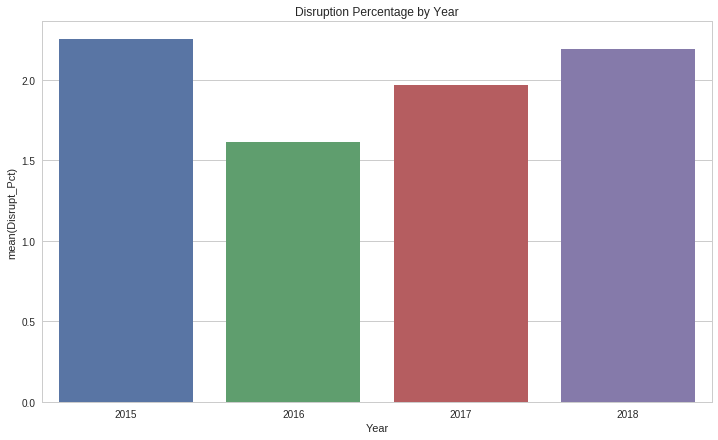

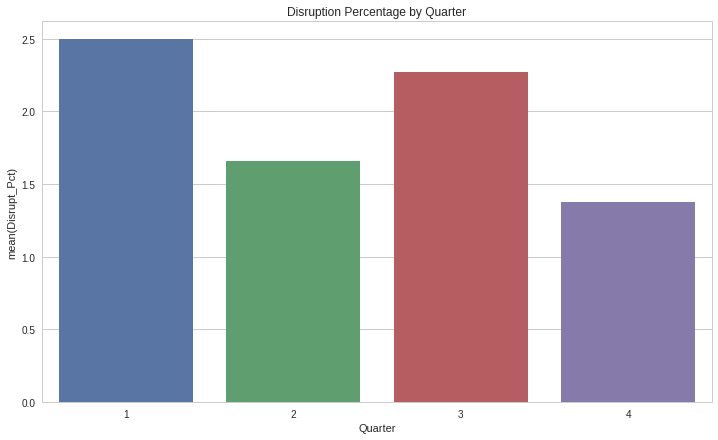

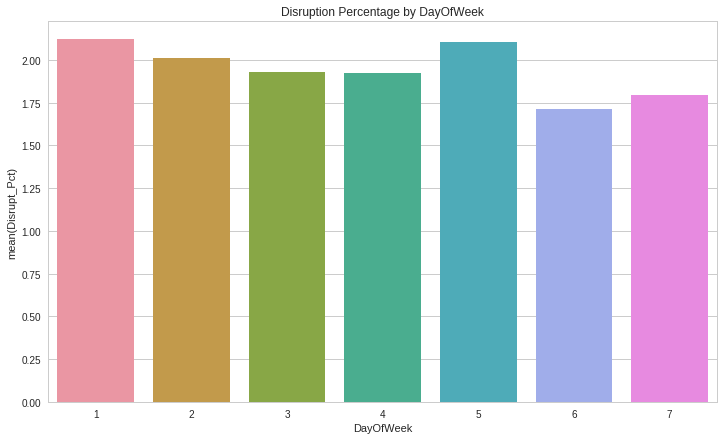

In [0]:
sns.set_style("whitegrid")
disrupt_rate_viz(other_df_list)

# Other Disruption Cost Visualizations

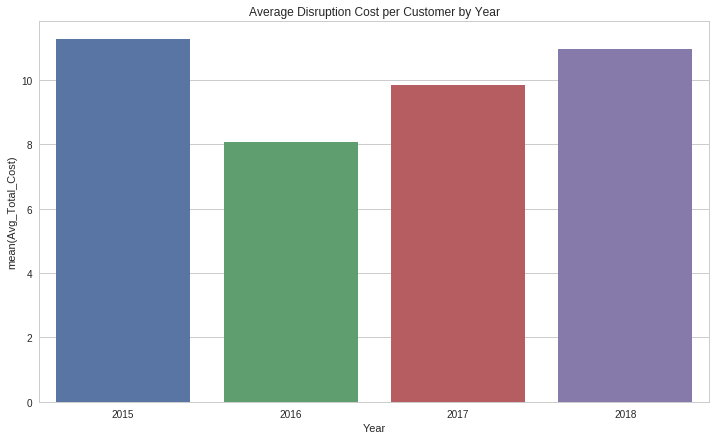

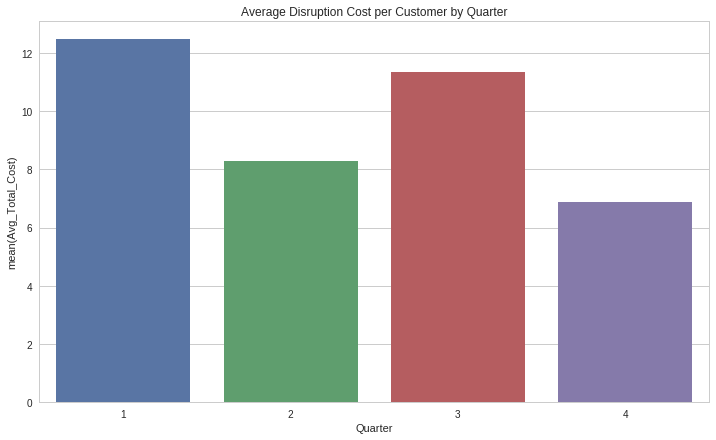

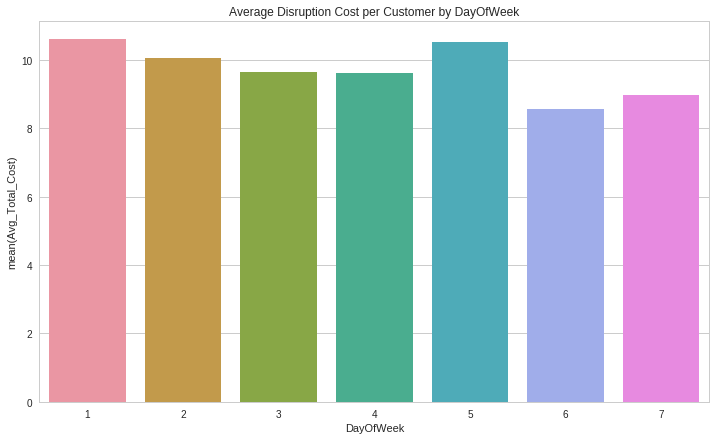

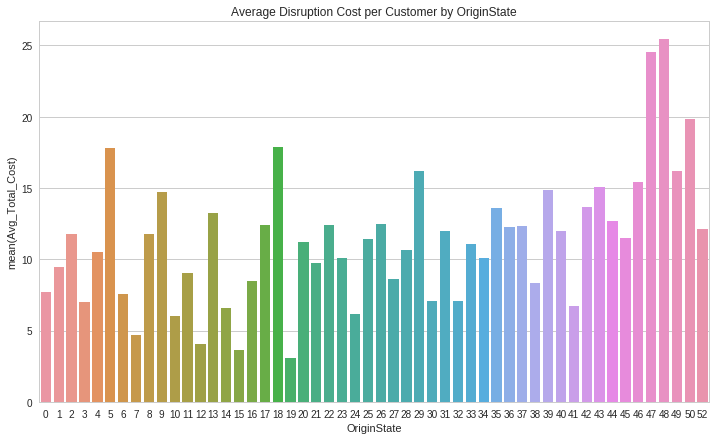

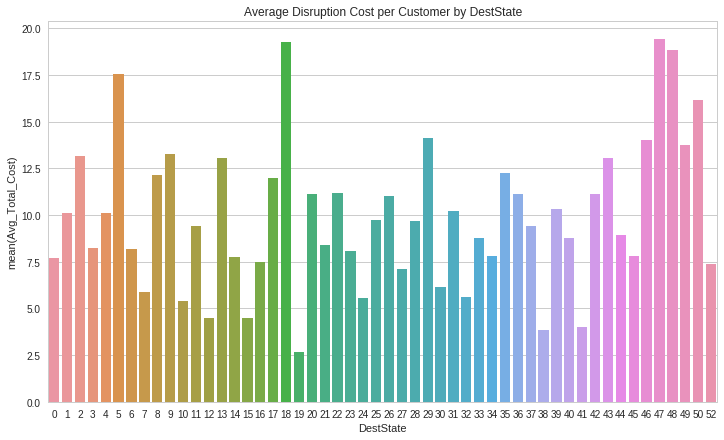

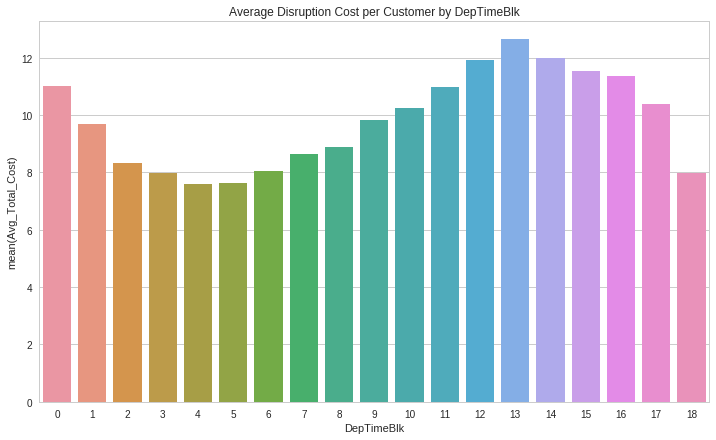

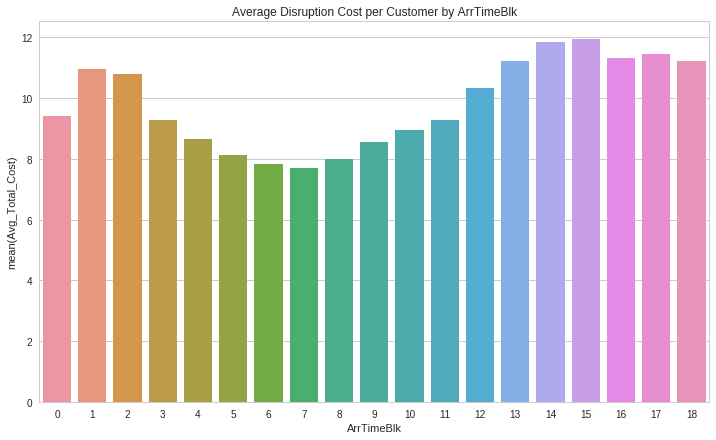

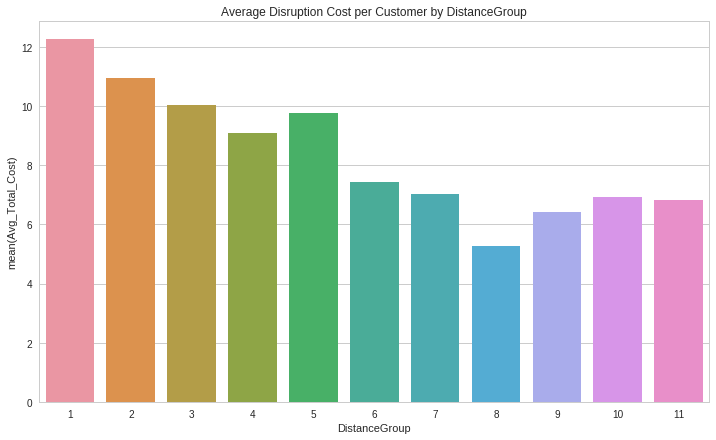

In [0]:
average_disrupt_cost_viz(other_df_list)

# Key Insights

* January has the highest disruption costs
* Winter months have highest cancellation rates; summer months have most flights delayed over 4+ hours
* New York area airports have the highest disruption costs of any major metro area; the Northeast US also has high disruption costs in general
* Weekend flights are less likely to be disrupted
* Short flights (under 250 miles) have higher disruption rates
* Envoy Air ,ExpressJet, PSA, Republic, and Endeavor are the worst airlines in terms of disruptions 
* Of the legacy carriers, American is the most costly to insure and Delta is the least costly
* Hawaiian Airlines, Delta, and Alaska are much less likely to experience disruptions



# Sample Data for Model

I sampled 1 million flights to create models to predict the cost of insuring against flight disruptions.

In [0]:
sample_df = df.sample(n=1000000, replace=True, random_state=66)

In [0]:
sample_df = sample_df[['Month', 'DayOfWeek', 'Carrier', 'Origin', 'OriginState', 'Dest', 'DestState', 
                       'CRSDepTime', 'CRSArrTime', 'ArrTimeBlk', 'Distance', 'DistanceGroup', 'Disruption',
                       'Cost', 'Carrier_MC', 'Dest_MC', 'Origin_MC', 'Month_MC', 'DayOfWeek_MC', 
                       'DepTimeBlk_MC', 'ArrTimeBlk_MC','OriginState_MC', 'DestState_MC']]

In [0]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 385852 to 17335936
Data columns (total 23 columns):
Month             1000000 non-null uint8
DayOfWeek         1000000 non-null uint8
Carrier           1000000 non-null uint8
Origin            1000000 non-null uint16
OriginState       1000000 non-null uint8
Dest              1000000 non-null uint16
DestState         1000000 non-null uint8
CRSDepTime        1000000 non-null uint16
CRSArrTime        1000000 non-null uint16
ArrTimeBlk        1000000 non-null uint8
Distance          1000000 non-null uint16
DistanceGroup     1000000 non-null uint8
Disruption        1000000 non-null uint8
Cost              1000000 non-null int64
Carrier_MC        1000000 non-null float32
Dest_MC           1000000 non-null float32
Origin_MC         1000000 non-null float32
Month_MC          1000000 non-null float32
DayOfWeek_MC      1000000 non-null float32
DepTimeBlk_MC     1000000 non-null float32
ArrTimeBlk_MC     1000000 non-null float32
O

In [0]:
# X and y variables for classification model
X_cl = sample_df.drop(['Disruption', 'Cost'], axis=1)
y_cl = sample_df['Disruption']

# X and y variables for regression model
X = sample_df.drop(['Disruption', 'Cost'], axis=1)
y = sample_df['Cost']

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=66)

# Tweedie Model

In [0]:
tweedie_model = sm.GLM(endog=y_train, exog=X_train, family=sm.families.Tweedie())

In [0]:
tweedie_results = tweedie_model.fit()

In [0]:
print(tweedie_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   Cost   No. Observations:               670000
Model:                            GLM   Df Residuals:                   669997
Model Family:                 Tweedie   Df Model:                            2
Link Function:                    log   Scale:              482.51809221499127
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sun, 24 Feb 2019   Deviance:                   4.9130e+07
Time:                        19:26:21   Pearson chi2:                 3.23e+08
No. Iterations:                    13                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Month              0.0019      0.003      0.658      0.511      -0.004       0.008
DayOfWeek         -0.0349      0.005    

In [0]:
tweedie_results.deviance

49130321.114821255

# Negative Binomial Model

In [0]:
neg_binom_model = sm.GLM(endog=y_train, exog=X_train, family=sm.families.NegativeBinomial())

In [0]:
neg_binom_results = neg_binom_model.fit()

In [0]:
print("Tweedie Model Deviance: ", tweedie_results.deviance)
print("Negative Binomial Model Deviance: ", neg_binom_results.deviance)

Tweedie Model Deviance:  49130321.114821255
Negative Binomial Model Deviance:  4027240.233803384


In [0]:
print(neg_binom_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   Cost   No. Observations:               670000
Model:                            GLM   Df Residuals:                   669997
Model Family:        NegativeBinomial   Df Model:                            2
Link Function:                    log   Scale:               61.41149672684344
Method:                          IRLS   Log-Likelihood:            -2.1093e+06
Date:                Sun, 24 Feb 2019   Deviance:                   4.0272e+06
Time:                        19:27:17   Pearson chi2:                 4.11e+07
No. Iterations:                    17                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Month              0.0043      0.003      1.255      0.209      -0.002       0.011
DayOfWeek         -0.0338      0.006    

# Average Cost of Feature Means Model

In [0]:
fm_model = X_test.copy()
fm_model = fm_model.drop(['Month', 'DayOfWeek', 'Carrier', 'Origin', 'OriginState', 'Dest',
       'DestState', 'CRSDepTime', 'CRSArrTime', 'ArrTimeBlk', 'Distance',
       'DistanceGroup'], axis=1)
print(fm_model.head())

          Carrier_MC  Dest_MC  Origin_MC  Month_MC  DayOfWeek_MC  \
14320714      10.899   10.948      9.500    11.479         9.635   
13166180       5.876    8.059     14.663     5.701        10.516   
2826787        9.225   11.203     10.310    10.318         8.573   
16989655      24.288   11.893     17.284     4.877         9.631   
1832611        9.225   16.192      6.940    11.479         8.573   

          DepTimeBlk_MC  ArrTimeBlk_MC  OriginState_MC  DestState_MC  
14320714          8.328          9.265           9.458        10.132  
13166180          9.693         10.784          12.464         8.225  
2826787           8.034          7.993          11.787        10.126  
16989655         10.988         10.325           6.998        12.119  
1832611           8.328          9.289           7.698        17.520  


In [0]:
fm_model['Avr_Cost_Model'] = fm_model.mean(axis=1)
print(fm_model.head(20))

          Carrier_MC  Dest_MC  Origin_MC  Month_MC  DayOfWeek_MC  \
14320714      10.899   10.948      9.500    11.479         9.635   
13166180       5.876    8.059     14.663     5.701        10.516   
2826787        9.225   11.203     10.310    10.318         8.573   
16989655      24.288   11.893     17.284     4.877         9.631   
1832611        9.225   16.192      6.940    11.479         8.573   
17642701       7.646    7.036      6.940    10.318         9.631   
277687        10.899   11.612     14.579    10.382        10.071   
1226786       17.263    8.691     17.920    10.106        10.516   
3526553       12.973   13.938      5.878    12.397        10.071   
10777314      17.263   15.463     17.920    10.106        10.603   
16150330       4.518    7.786     10.188    12.397         9.631   
7566763       14.274   16.192     13.104    12.397         8.573   
14212057       7.646    5.434     10.188    11.479         8.573   
11197556       7.646   10.889      5.878    10.3

In [0]:
fm_model['Tweedie_Model'] = tweedie_results.predict(X_test)

In [0]:
fm_model['Neg_Binom_Model'] = neg_binom_results.predict(X_test)

In [0]:
predictions_df = fm_model[['Tweedie_Model', 'Neg_Binom_Model', 'Avr_Cost_Model']].copy()
predictions_df['Ensemble_Pred'] = predictions_df.mean(axis=1)
print(predictions_df.head(50))

          Tweedie_Model  Neg_Binom_Model  Avr_Cost_Model  Ensemble_Pred
14320714         11.095           11.902           9.961         10.986
13166180          5.167            5.416           9.553          6.712
2826787           8.349            8.791           9.730          8.957
16989655         18.681           21.431          12.045         17.386
1832611           9.138            8.340          10.583          9.353
17642701          5.499            5.596           8.074          6.390
277687           11.161           15.434           9.895         12.163
1226786          19.050           17.188          12.610         16.283
3526553          10.179           10.370          10.107         10.219
10777314         24.665           24.175          13.394         20.744
16150330          9.472            8.928           9.421          9.274
7566763          34.283           30.224          13.246         25.918
14212057          8.631            8.962           8.989        

# Test Data

Run negative binomial model on test data

In [0]:
# download sample data for project
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving sample_data_for_project.csv to sample_data_for_project.csv
User uploaded file "sample_data_for_project.csv" with length 103941 bytes


In [0]:
!ls

on_time_2016.csv  on_time_2018.csv
on_time_2017.csv  sample_data_for_project.csv


In [0]:
test_df = pd.read_csv('sample_data_for_project.csv')

In [0]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2589 entries, 0 to 2588
Data columns (total 7 columns):
departure_date    2589 non-null object
departure_time    2589 non-null object
Origin            2589 non-null object
Dest              2589 non-null object
Carrier           2589 non-null object
FlightNum         2589 non-null int64
passenger_id      2589 non-null int64
dtypes: int64(2), object(5)
memory usage: 141.7+ KB


In [0]:
# convert departure data to datetime
test_df['departure_date'] = pd.to_datetime(test_df['departure_date'])
test_df['departure_time'] = pd.to_datetime(test_df['departure_time'])

In [0]:
# create function to extract datetime features
def date_extraction(feature):
  month_list = []
  day_of_week_list = []  
  
  for i in feature:
    month_list.append(i.month)
    day_of_week_list.append(i.dayofweek)
    
  return month_list, day_of_week_list

In [0]:
# create function to extract datetime features
def time_extraction(feature):
  hour_list = []
  
  for i in feature:
    hour_list.append(i.hour)
    
  return hour_list

In [0]:
# Extract date and time features
test_df['Month'] = date_extraction(test_df['departure_date'])[0]
test_df['DayOfWeek'] = date_extraction(test_df['departure_date'])[1]
test_df['DayOfWeek'] = test_df['DayOfWeek'] + 1
test_df['DepTimeBlk'] = time_extraction(test_df['departure_time'])
test_df = test_df.drop(['departure_date', 'departure_time', 'FlightNum'], axis=1)

In [0]:
# use dictionary to assign numeric value to origin, dest, and carrier
test_df['Carrier'] = test_df['Carrier'].map(carrier_dict).fillna(15).astype(int)
test_df['Dest'] = test_df['Dest'].map(airport_dict).fillna(0).astype(int)
test_df['Origin'] = test_df['Origin'].map(airport_dict).fillna(0).astype(int)

In [0]:
# convert hour to time blocks
test_df['DepTimeBlk'] = test_df['DepTimeBlk'].map(hour_dict).fillna(0).astype(int)

In [0]:
# mean cost map features
test_df['Carrier_MC'] = test_df['Carrier'].map(mean_cost_map(df['Carrier']))
test_df['Dest_MC'] = test_df['Dest'].map(mean_cost_map_dest_airport(df['Dest']))
test_df['Origin_MC'] = test_df['Origin'].map(mean_cost_map_origin_airport(df['Origin']))
test_df['Month_MC'] = test_df['Month'].map(mean_cost_map(df['Month']))
test_df['DayOfWeek_MC'] = test_df['DayOfWeek'].map(mean_cost_map(df['DayOfWeek']))
test_df['DepTimeBlk_MC'] = test_df['DepTimeBlk'].map(mean_cost_map(df['DepTimeBlk']))

In [0]:
# test_df = test_df.drop(['Origin', 'Dest', 'Carrier', 'passenger_id', 'Month', 'DayOfWeek', 
#                         'DepTimeBlk', ], axis=1)

In [0]:
test_df.head()

,Origin,Dest,Carrier,passenger_id,Month,DayOfWeek,DepTimeBlk,Carrier_MC,Dest_MC,Origin_MC,Month_MC,DayOfWeek_MC,DepTimeBlk_MC
0,278,314,0,0,8,5,1,7.646,13.022,10.954,12.397,10.516,9.693
1,304,323,0,1,12,6,5,7.646,7.712,6.940,10.318,8.573,7.611
2,168,309,1,2,3,4,1,5.876,4.536,6.134,11.554,9.631,9.693
3,126,325,4,3,9,7,13,10.899,13.938,19.854,10.106,8.966,12.635
4,302,312,11,4,7,1,2,12.973,20.968,10.948,11.479,10.603,8.328


In [0]:
X_test = test_df

In [0]:
X_small = X[['Origin', 'Dest', 'Carrier', 'Month', 'DayOfWeek',
       'Carrier_MC', 'Dest_MC', 'Origin_MC', 'Month_MC',
       'DayOfWeek_MC', 'DepTimeBlk_MC']]

In [0]:
X_test = X_test[['Origin', 'Dest', 'Carrier', 'Month', 'DayOfWeek',
       'Carrier_MC', 'Dest_MC', 'Origin_MC', 'Month_MC',
       'DayOfWeek_MC', 'DepTimeBlk_MC']]

In [0]:
neg_binom_model_test = sm.GLM(endog=y, exog=X_small, family=sm.families.NegativeBinomial())

In [0]:
neg_binom_results_test = neg_binom_model_test.fit()

In [0]:
neg_binom_predict = neg_binom_results_test.predict(X_test)

In [0]:
neg_binom_predict[:30]

0    11.136
1     4.945
2     5.099
3    27.317
4    22.131
5     5.233
6     5.233
7    16.154
8    12.031
9    11.352
10    5.414
11    4.652
12   12.150
13   12.987
14    9.076
15    8.025
16   18.785
17    4.857
18    4.857
19    3.688
20   10.085
21   10.085
22   12.005
23   21.393
24   12.602
25   13.008
26    4.382
27    4.382
28   14.301
29    7.000
dtype: float64

In [0]:
# def output_test_predictions(type):
#     model = type
#     name = str(type).split('(')[0]
#     model_fit = model.fit(X_train, y_train)
#     model_preds = model.predict(X_test)
    
#     print("completed!")
#     return model_preds

# Cost to Insure Prediction Function

In [0]:
def predict_cost_to_insure(carrier=['DL'], origin=['ATL'], dest=['BOS'], month=[6], dayofweek=[1], hour=[7]):
    data_dict = {'Carrier':carrier, 'Origin': origin, 'Dest': dest, 'Month': month, 
                 'DayOfWeek': dayofweek, 'DepTimeBlk': hour}
    test_df = pd.DataFrame(data=data_dict)
    
        
    # use dictionary to assign numeric value to origin, dest, and carrier
    test_df['Carrier'] = test_df['Carrier'].map(carrier_dict).fillna(15).astype(int)
    test_df['Dest'] = test_df['Dest'].map(airport_dict).fillna(0).astype(int)
    test_df['Origin'] = test_df['Origin'].map(airport_dict).fillna(0).astype(int)
    
    # convert hour to time blocks
    test_df['DepTimeBlk'] = test_df['DepTimeBlk'].map(hour_dict).fillna(0).astype(int)
    
    # mean cost map features
    test_df['Carrier_MC'] = test_df['Carrier'].map(mean_cost_map(df['Carrier']))
    test_df['Dest_MC'] = test_df['Dest'].map(mean_cost_map_dest_airport(df['Dest']))
    test_df['Origin_MC'] = test_df['Origin'].map(mean_cost_map_origin_airport(df['Origin']))
    test_df['Month_MC'] = test_df['Month'].map(mean_cost_map(df['Month']))
    test_df['DayOfWeek_MC'] = test_df['DayOfWeek'].map(mean_cost_map(df['DayOfWeek']))
    test_df['DepTimeBlk_MC'] = test_df['DepTimeBlk'].map(mean_cost_map(df['DepTimeBlk']))

    # create training df
    train_df = sample_df[['Carrier', 'DayOfWeek', 'Dest', 'Month', 'Origin',
       'Carrier_MC', 'Dest_MC', 'Origin_MC', 'Month_MC', 'DayOfWeek_MC',
       'DepTimeBlk_MC', 'Cost']]
    
    # create x and y
    X_train = train_df.drop(['Cost'], axis=1)
    y_train = train_df['Cost']
    X_test = test_df.drop(['DepTimeBlk'], axis=1)
    
    # create negative binomail model
    neg_binom_model = sm.GLM(endog=y_train, exog=X_train, family=sm.families.NegativeBinomial())
    neg_binom_results = neg_binom_model.fit()
    neg_binom_predict = neg_binom_results.predict(X_test)
    
    return neg_binom_predict


In [0]:
# default: Atlanta to Logan (BOS) in June on a Monday with Delta at 7AM
predict_cost_to_insure()

0   6.231
dtype: float64

In [0]:
# O'Hare to Logan on Monday in February with Delta at 7AM
predict_cost_to_insure(month=[2], origin=['ORD'])

0   9.177
dtype: float64

In [0]:
# Newark to Logan on Monday in February with JetBlue at 7AM
predict_cost_to_insure(month=[2], origin=['NWK'], carrier='B6')

0   19.181
dtype: float64